In [ ]:
from google.colab import files
upload = files.upload()

Saving functions.py to functions.py


In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("keras_tuner")
install("scikeras")
install("pandas_ta")
install("fredapi")
install("hyperopt")
install('quantstats')

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from numpy import sort
import yfinance as yf
import tensorflow as tf
from functions import *
import quantstats as qs

SEED = 123
DATA_SPLIT_PCT = 0.2

# Set the random seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. DATA COLLECTION



## 1a. Historical Price Data

In [ ]:
# Import Close Price, Volume, Open Price, High Price, Low Price
## Fetch BTC stock data
symbols = ['BTC-USD']
start_date = '2014-01-01'
end_date = '2024-08-01'
price_data = download_yahoo_finance(symbols,start_date=start_date,end_date=end_date)
price_data = price_data[['Open', 'High', 'Low', 'Close', 'Volume']]
price_data['Volume'] = price_data['Volume'].astype(float)

## Calculate perchange change for lag 1
price_data = lag_data(price_data)
price_data.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close      Volume  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  
Date                                                                 
2014-09-17        NaN        NaN       NaN         NaN          NaN  
2014-09-18  -0.019328  -0.024166 -0.086906   -0.071926     0.637628  
2014-09-19  -0.071700  -0.063531 -0.069164   -0.069843     0.099657  
2014-09-20  -0.069394  -0.010609  0.013916    0.035735    -0.027851  
2014-09-21   0.033983  -0.025679  0.008459   -0.024659    -0.278961

## 1b. Technical Indicators

In [ ]:
price_data = calculate_indicators(price_data)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3607 entries, 2014-09-17 to 2024-08-01
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3607 non-null   float64
 1   High            3607 non-null   float64
 2   Low             3607 non-null   float64
 3   Close           3607 non-null   float64
 4   Volume          3607 non-null   float64
 5   Open_lag1       3606 non-null   float64
 6   High_lag1       3606 non-null   float64
 7   Low_lag1        3606 non-null   float64
 8   Close_lag1      3606 non-null   float64
 9   Volume_lag1     3606 non-null   float64
 10  Return_lag10    3597 non-null   float64
 11  RSI_14          3593 non-null   float64
 12  RSI_6           3601 non-null   float64
 13  RSI_5           3602 non-null   float64
 14  %K              3592 non-null   float64
 15  %D              3590 non-null   float64
 16  SMA5            3603 non-null   float64
 17  SMA10          

## 1c. Macroeconomic Data


In [ ]:
## Fetch macroeconomic data
symbols = ['INR=X', 'CNY=X', 'BRL=X', 'VND=X', 'CL=F', 'GC=F', 'SI=F', '^GSPC', '^TNX', '^FVX']
macro_data = download_yahoo_finance(symbols, start_date, end_date)['Close']

## Convert both indexes to tz-aware DatetimeIndex
macro_data.index = macro_data.index.tz_localize(None)

## Rename
macro_data.rename(columns={
    'INR=X': 'USD/INR',
    'CNY=X': 'USD/CNY',
    'BRL=X': 'USD/BRL',
    'VND=X': 'USD/VND',
    'CL=F': 'Crude_Oil',
    'GC=F': 'Gold',
    '^GSPC': 'S&P500',
    'SI=F': 'Silver',
    '^FVX': '10Y_TB',
    '^TNX': '5Y_TB',}, inplace=True)

[*********************100%***********************]  10 of 10 completed


In [ ]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2656 entries, 2014-01-02 to 2024-08-01
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USD/BRL    2656 non-null   float64
 1   Crude_Oil  2656 non-null   float64
 2   USD/CNY    2656 non-null   float64
 3   Gold       2656 non-null   float64
 4   USD/INR    2656 non-null   float64
 5   Silver     2656 non-null   float64
 6   USD/VND    2656 non-null   float64
 7   10Y_TB     2656 non-null   float64
 8   S&P500     2656 non-null   float64
 9   5Y_TB      2656 non-null   float64
dtypes: float64(10)
memory usage: 228.2 KB


# 2. DATA PRE-PROCESSING

## 2a. Data Cleaning

In [ ]:
# Merge all data
btc_data = pd.concat([price_data, macro_data], axis=1, join="inner")
btc_data = btc_data.dropna()
btc_data.head()

Open        High         Low       Close      Volume  \
Date                                                                     
2014-10-20  389.230988  390.084015  378.252014  382.845001  16419000.0   
2014-10-21  382.420990  392.645996  380.834015  386.475006  14188900.0   
2014-10-22  386.118011  388.575989  382.248993  383.157990  11641300.0   
2014-10-23  382.962006  385.048004  356.446991  358.416992  26456900.0   
2014-10-24  358.591003  364.345001  353.304993  358.345001  15585700.0   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  ...  \
Date                                                                 ...   
2014-10-20  -0.005171  -0.009786 -0.021231   -0.017202     1.776026  ...   
2014-10-21  -0.017496   0.006568  0.006826    0.009482    -0.135824  ...   
2014-10-22   0.009667  -0.010366  0.003715   -0.008583    -0.179549  ...   
2014-10-23  -0.008174  -0.009079 -0.067501   -0.064571     1.272676  ...   
2014-10-24  -0.063638  -0.053767 -0.008815   -0.000201    -0.410902  ...   

            USD/BRL  Crude_Oil  USD/CNY         Gold    USD/INR     Silver  \
Date                                                                         
2014-10-20   2.4307  82.709999   6.1140  1244.000000  61.358002  17.304001   
2014-10-21   2.4622  82.809998   6.1136  1251.000000  61.228001  17.504000   
2014-10-22   2.4780  80.519997   6.1110  1244.800049  61.143002  17.186001   
2014-10-23   2.4843  82.089996   6.1083  1228.500000  61.099998  17.114000   
2014-10-24   2.4957  81.010002   6.1095  1231.199951  61.130001  17.136000   

            USD/VND  10Y_TB       S&P500  5Y_TB  
Date                                             
2014-10-20  20943.0   1.395  1904.010010  2.181  
2014-10-21  21019.0   1.410  1941.280029  2.208  
2014-10-22  20899.0   1.441  1927.109985  2.229  
2014-10-23  20981.0   1.494  1950.819946  2.275  
2014-10-24  20930.0   1.497  1964.579956  2.273  

[5 rows x 38 columns]

In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2455 entries, 2014-10-20 to 2024-08-01
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2455 non-null   float64
 1   High            2455 non-null   float64
 2   Low             2455 non-null   float64
 3   Close           2455 non-null   float64
 4   Volume          2455 non-null   float64
 5   Open_lag1       2455 non-null   float64
 6   High_lag1       2455 non-null   float64
 7   Low_lag1        2455 non-null   float64
 8   Close_lag1      2455 non-null   float64
 9   Volume_lag1     2455 non-null   float64
 10  Return_lag10    2455 non-null   float64
 11  RSI_14          2455 non-null   float64
 12  RSI_6           2455 non-null   float64
 13  RSI_5           2455 non-null   float64
 14  %K              2455 non-null   float64
 15  %D              2455 non-null   float64
 16  SMA5            2455 non-null   float64
 17  SMA10          

**Data Visualization**

<Figure size 1600x1000 with 0 Axes>

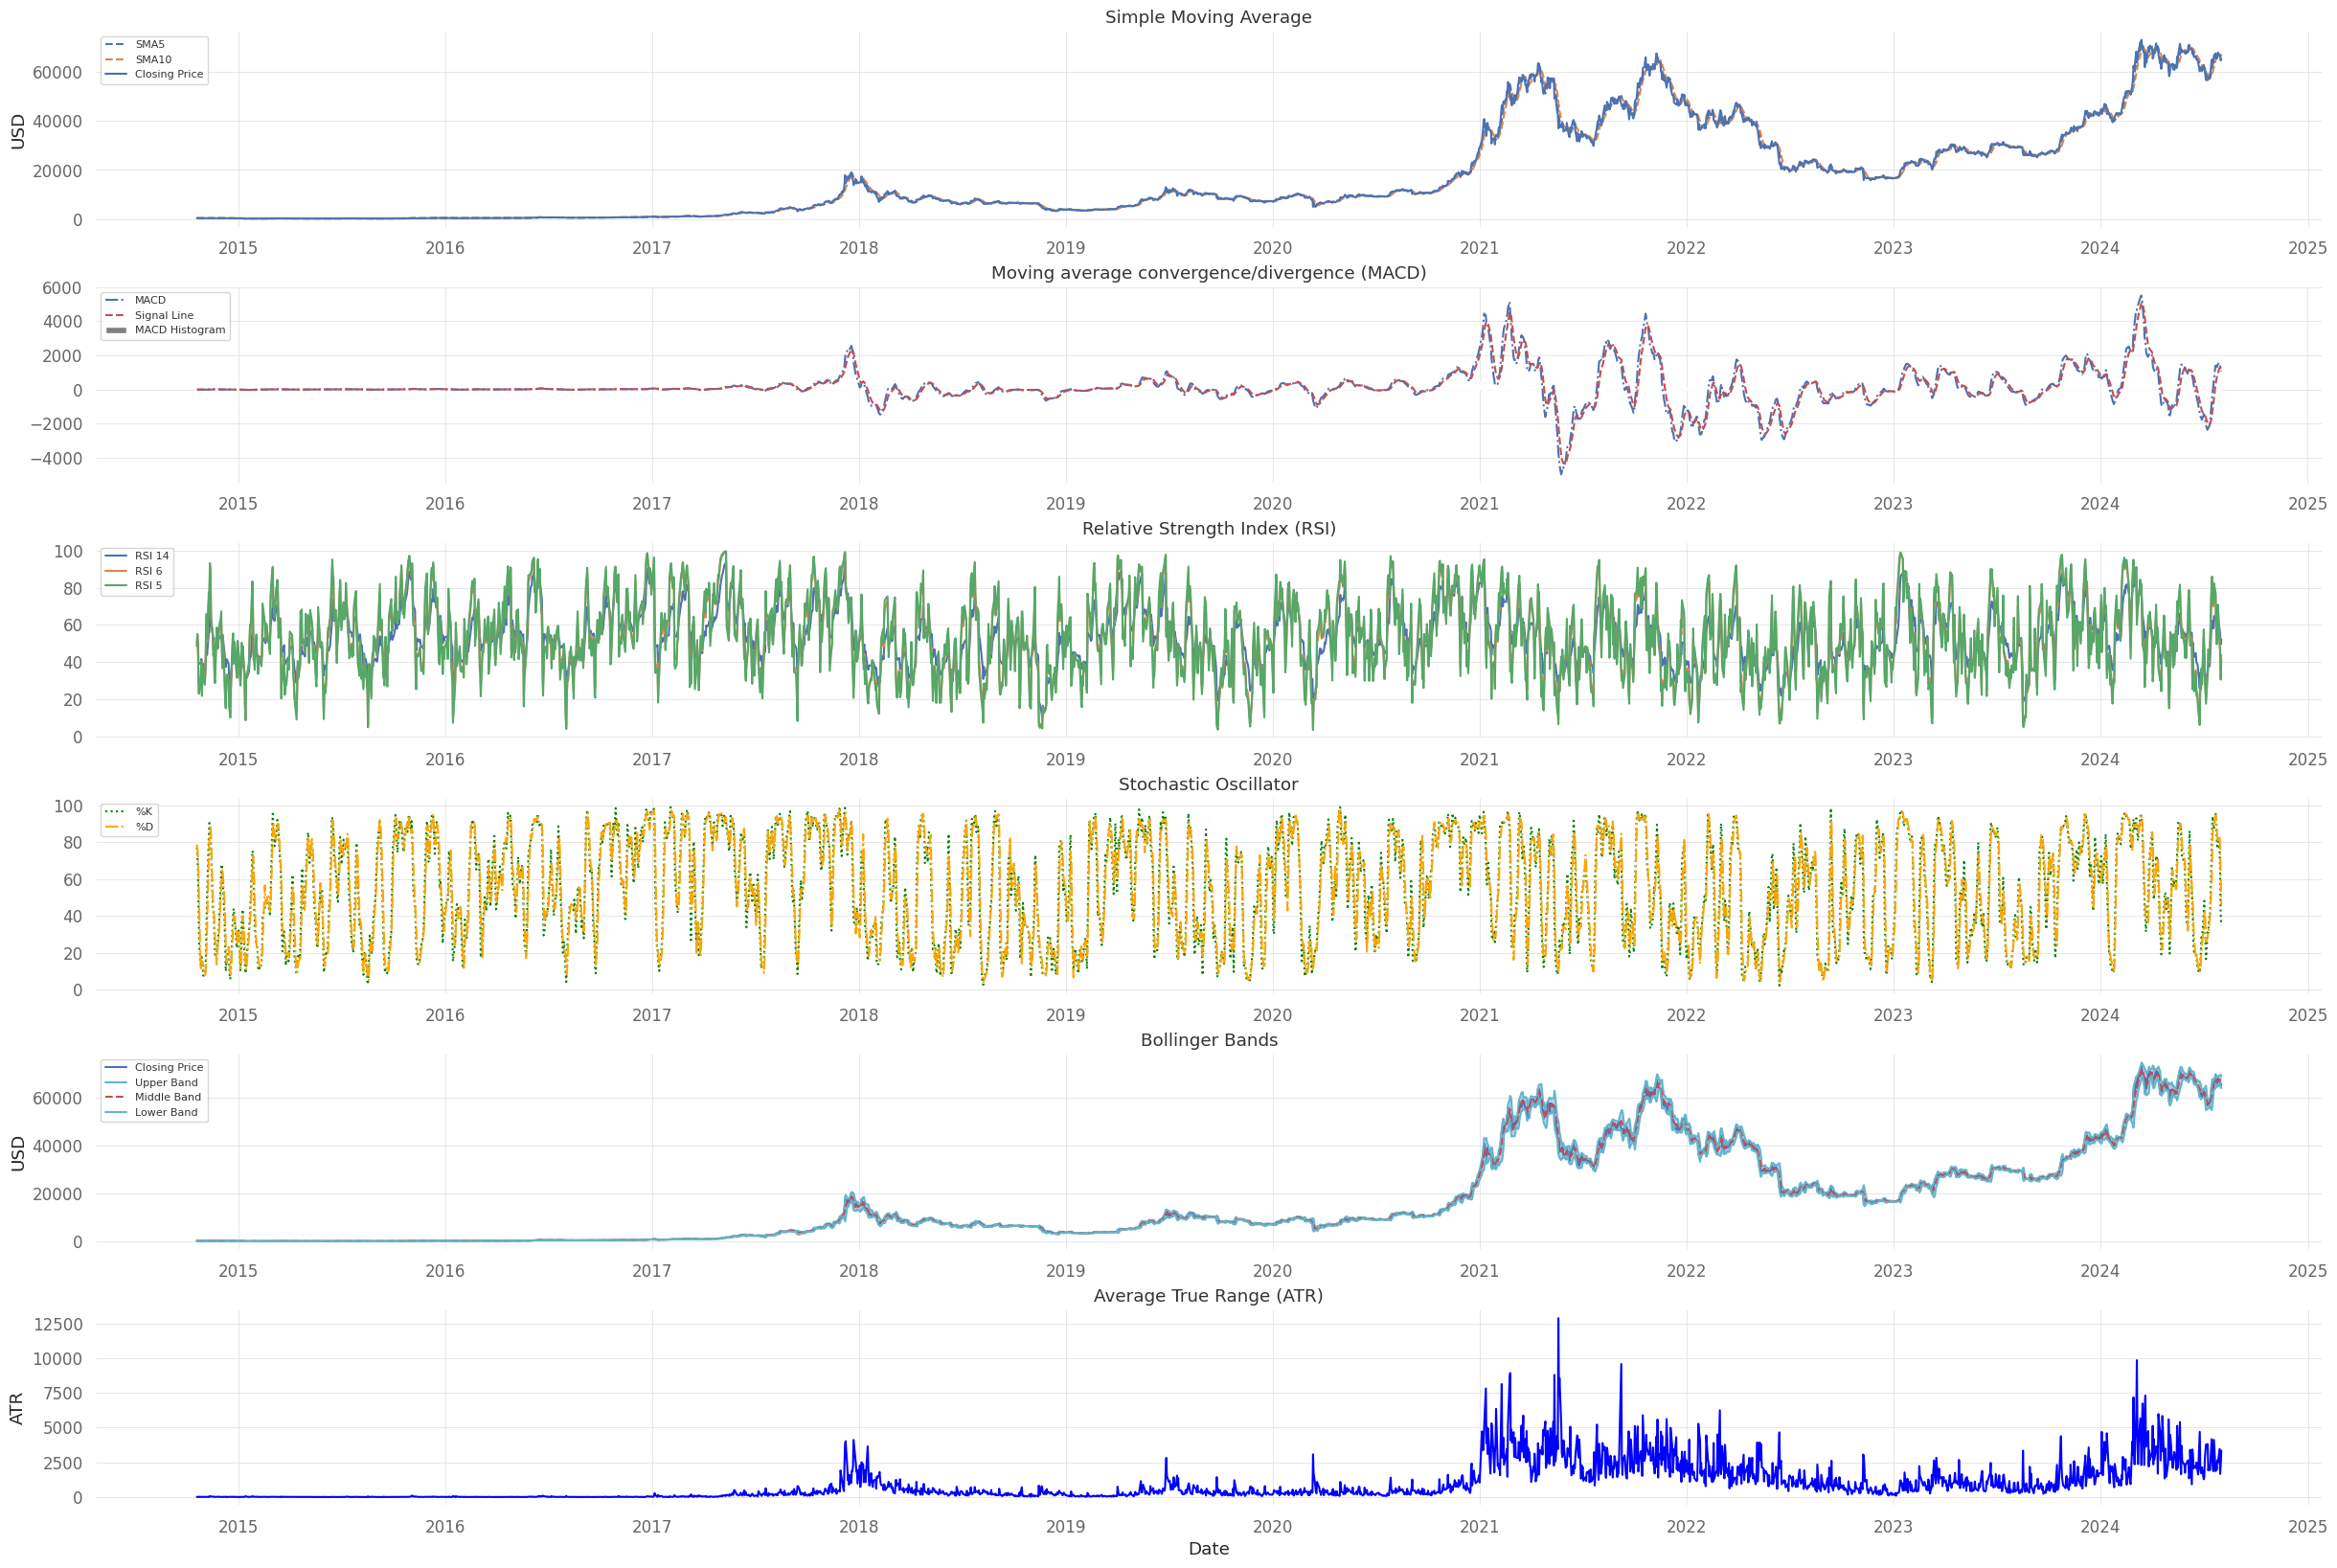

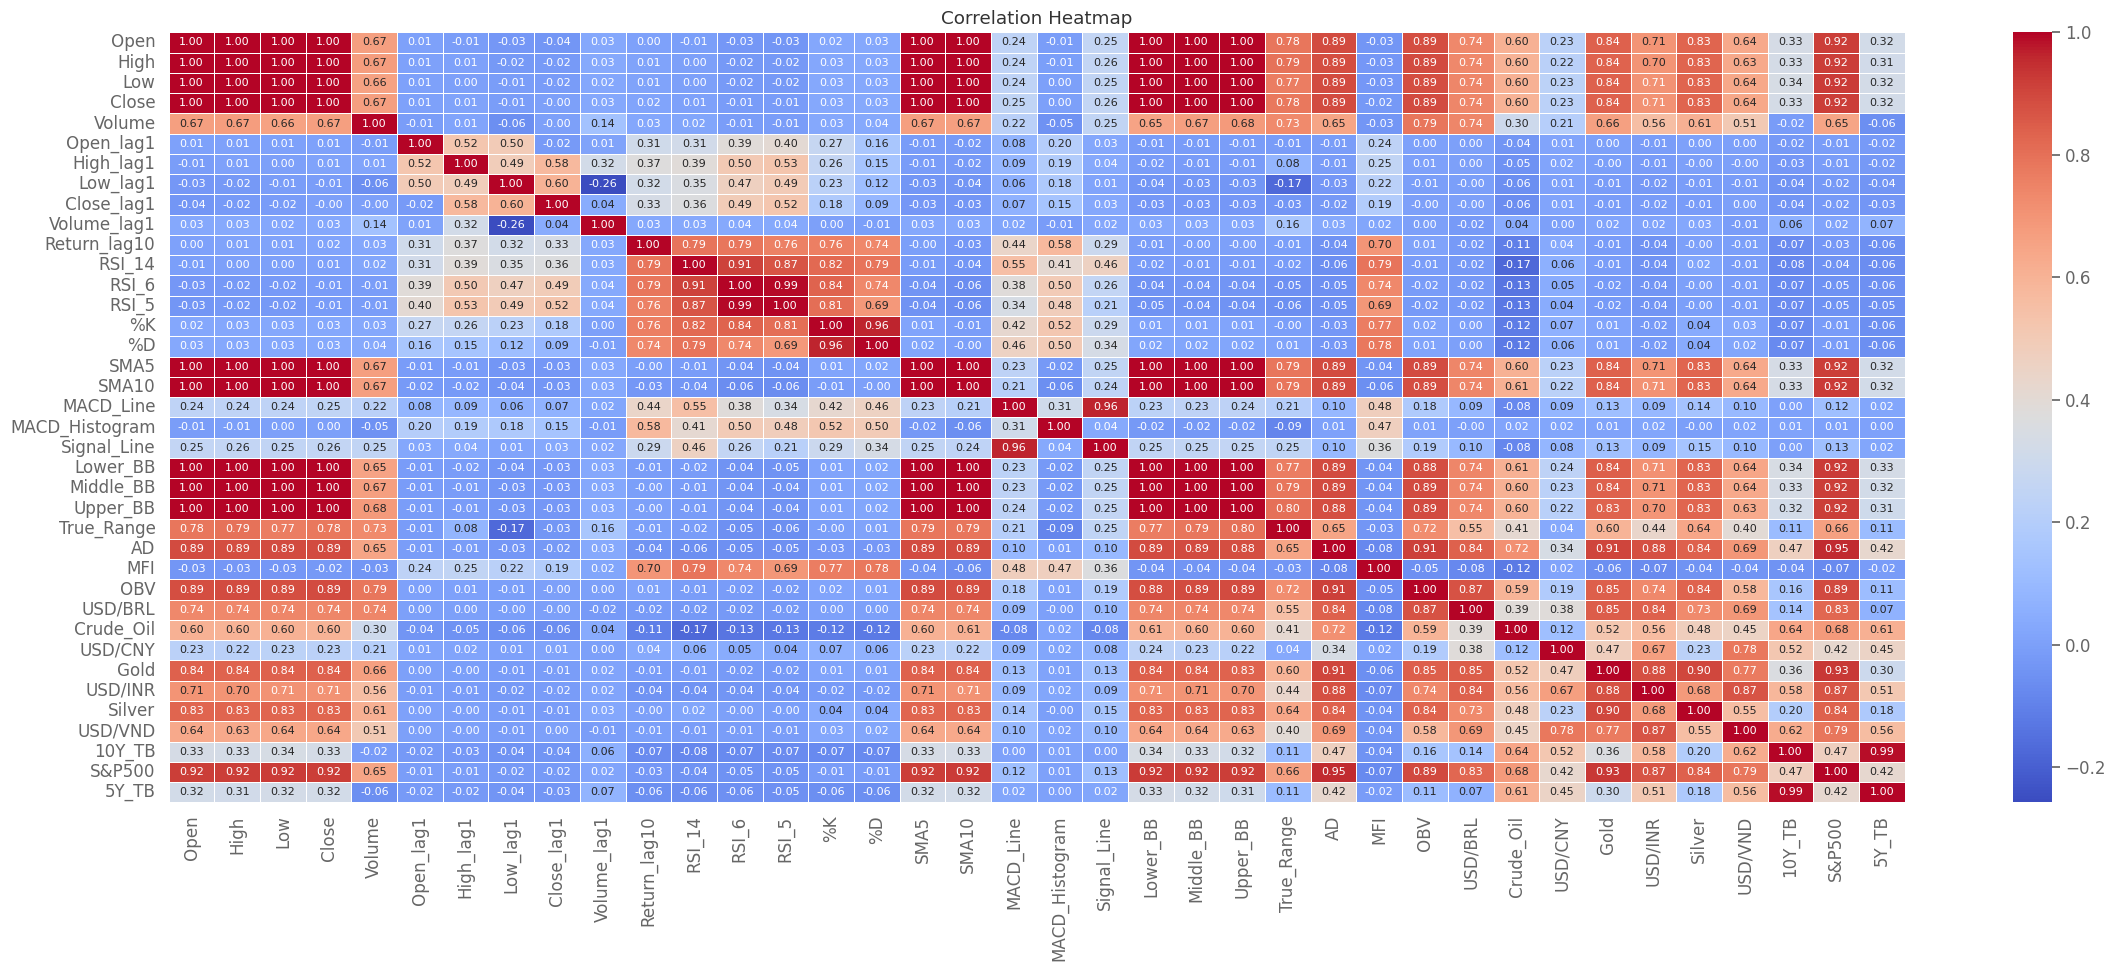

In [ ]:
# Plot technical indicators
plot_technical_indicators(btc_data, 2455)

plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(btc_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
heatmap.set_title('Correlation Heatmap');

High Correlation with Close:


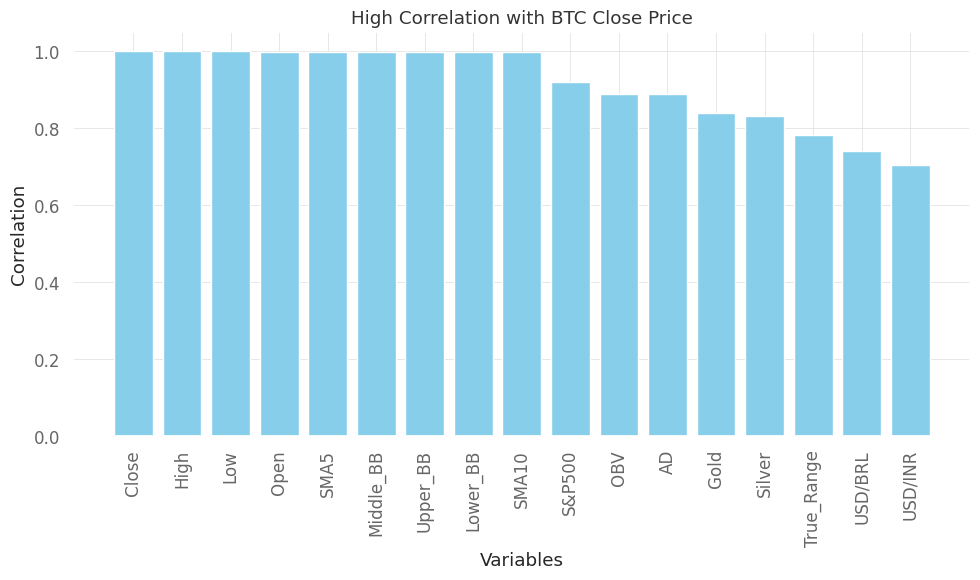

In [ ]:
high_correlation_df = high_correlation(btc_data, 'Close', threshold=0.7)

# Plot the high correlation variables with 'Close' using a bar plot
plt.bar(high_correlation_df.index, high_correlation_df, color='skyblue')
plt.title('High Correlation with BTC Close Price')
plt.ylabel('Correlation')
plt.xlabel('Variables')
plt.xticks(rotation=90)

# Save the plot as an image
plt.tight_layout()
plt.savefig('high_correlation_barplot.png', dpi=300)
plt.show()

## 2b. Feature Selection: XGBRegressor

In [ ]:
# Load the data
target_column = 'Close'
X_xgboost = btc_data.loc[:, btc_data.columns != target_column]
y_xgboost = btc_data[target_column].values

# Splitting
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size = DATA_SPLIT_PCT, shuffle = False)

# Scale the data
scaler_xgboost = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_xgboost = scaler_xgboost.fit_transform(X_train_xgboost)
X_test_scaled_xgboost = scaler_xgboost.transform(X_test_xgboost)

# Define the objective function
def objective(params):
    # Create XGBoost model with hyperparameters
    model = xg.XGBRegressor(
        objective='reg:squarederror',
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        random_state=SEED
    )

    # Train the model
    model.fit(X_train_scaled_xgboost, y_train_xgboost)

    # Make predictions
    predictions = model.predict(X_test_scaled_xgboost)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))

    return {'loss': rmse, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'max_depth': hp.uniform('max_depth', 0, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'learning_rate': hp.uniform('learning_rate', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 1, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1)
}

# Create Trials object to store results
trials = Trials()

# Run Bayesian optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Number of iterations
    trials=trials
)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [17:12<00:00, 10.32s/trial, best loss: 1542.3263078947496]
Best hyperparameters: {'learning_rate': 0.12957920559050318, 'max_depth': 0.38141864221721555, 'n_estimators': 233.0, 'reg_alpha': 0.005296027712694162, 'reg_lambda': 1.144486469471953}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12957920559050318,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=233, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Apply best parameters to train final model
best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha']}

# Create final XGBoost model with best hyperparameters
final_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED
)

# Train the model
final_model.fit(X_train_scaled_xgboost, y_train_xgboost)

In [ ]:
# Save the model
#final_model.save_model('XGBRegressor_BTC.json')

# Upload the saved model
loaded_model = xg.XGBRegressor()
loaded_model.load_model('XGBRegressor_BTC.json')

In [ ]:
# Prediction
y_pred_xgboost = final_model.predict(X_test_scaled_xgboost)
predictions = [round(value) for value in y_pred_xgboost]

# RMSE computation
rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
print("RMSE: % f" %(rmse))

rmses = []
num_features = []

# Fit model using each importancce as a threshold
thresholds = sort(final_model.feature_importances_)
for thresh in thresholds:
  selection = SelectFromModel(final_model, threshold=thresh, prefit = True)
  select_X_train = selection.transform(X_train_scaled_xgboost)

  # train model
  selection_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED)
  selection_model.fit(select_X_train, y_train_xgboost)

  # evaluate model
  select_X_test = selection.transform(X_test_scaled_xgboost)
  predictions = selection_model.predict(select_X_test)
  rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
  rmses.append(rmse)
  num_features.append(select_X_train.shape[1])
  print("Thresh=%.3f, n=%d, RMSE: %f" %(thresh, select_X_train.shape[1], rmse))

RMSE:  1542.343957
Thresh=0.000, n=37, RMSE: 1542.326308
Thresh=0.000, n=36, RMSE: 1542.326308
Thresh=0.000, n=35, RMSE: 1551.156004
Thresh=0.000, n=34, RMSE: 1588.745437
Thresh=0.000, n=33, RMSE: 1693.261076
Thresh=0.000, n=32, RMSE: 1560.887812
Thresh=0.000, n=31, RMSE: 1591.036816
Thresh=0.000, n=30, RMSE: 1574.712201
Thresh=0.000, n=29, RMSE: 1575.659643
Thresh=0.000, n=28, RMSE: 1529.006972
Thresh=0.000, n=27, RMSE: 1592.088350
Thresh=0.000, n=26, RMSE: 1613.786093
Thresh=0.000, n=25, RMSE: 1610.833920
Thresh=0.000, n=24, RMSE: 1658.680005
Thresh=0.000, n=23, RMSE: 1626.606012
Thresh=0.000, n=22, RMSE: 1631.186922
Thresh=0.000, n=21, RMSE: 1627.273197
Thresh=0.000, n=20, RMSE: 1671.797813
Thresh=0.000, n=19, RMSE: 1632.787894
Thresh=0.000, n=18, RMSE: 1520.369954
Thresh=0.000, n=17, RMSE: 1574.515978
Thresh=0.000, n=16, RMSE: 1508.361957
Thresh=0.000, n=15, RMSE: 1467.281715
Thresh=0.000, n=14, RMSE: 1446.293465
Thresh=0.000, n=13, RMSE: 1351.443642
Thresh=0.000, n=12, RMSE: 1620.

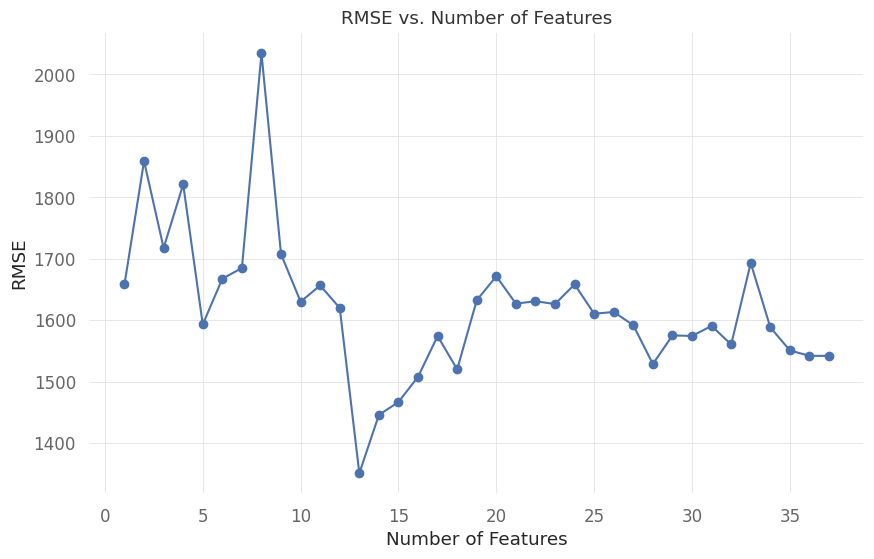

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, rmses, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Features')
plt.show()

In [ ]:
# Feature Importance
feature_importance_df = pd.DataFrame(final_model.feature_importances_, columns=['Importance'])
feature_importance_df['Feature'] = X_xgboost.columns

# Sort the DataFrame by 'Importance' in descending order
feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)
feature_importance_df

Importance         Feature
21  0.000000e+00       Middle_BB
25  5.708185e-07             MFI
18  1.057682e-06  MACD_Histogram
13  1.083438e-06              %K
27  1.277248e-06         USD/BRL
14  1.355156e-06              %D
28  1.369467e-06       Crude_Oil
8   1.419731e-06     Volume_lag1
19  1.859609e-06     Signal_Line
33  2.074758e-06         USD/VND
34  2.095754e-06          10Y_TB
17  2.389373e-06       MACD_Line
31  2.513619e-06         USD/INR
4   2.567865e-06       Open_lag1
23  2.870401e-06      True_Range
30  3.049245e-06            Gold
9   3.104669e-06    Return_lag10
6   3.128972e-06        Low_lag1
36  3.576509e-06           5Y_TB
29  3.707255e-06         USD/CNY
5   5.428997e-06       High_lag1
11  6.109335e-06           RSI_6
3   9.039285e-06          Volume
10  9.227007e-06          RSI_14
12  1.121371e-05           RSI_5
32  1.518171e-05          Silver
35  2.423701e-05          S&P500
0   5.462757e-05            Open
7   9.755680e-05      Close_lag1
26  1.708090e-04             OBV
16  1.981186e-04           SMA10
15  5.577492e-04            SMA5
24  6.235953e-04              AD
22  3.996925e-02        Upper_BB
1   9.508630e-02            High
20  2.008864e-01        Lower_BB
2   6.622341e-01             Low



- We select the set of features with the lowest RMSE.



In [ ]:
column_to_select = ['Low', 'Lower_BB', 'High', 'Upper_BB', 'AD', 'SMA5','SMA10','OBV','Close_lag1','Open','S&P500','Silver','RSI_5','Close']
btc_data_1 = btc_data[column_to_select].copy()
btc_data_1 = btc_data_1.dropna()
btc_data_1.tail()

Low      Lower_BB          High      Upper_BB  \
Date                                                                 
2024-07-26  65743.765625  64457.175287  68207.601562  68572.562213   
2024-07-29  66532.593750  65504.624473  69987.539062  69126.738027   
2024-07-30  65323.191406  65866.913580  66987.671875  68933.964545   
2024-07-31  64532.046875  64173.708852  66810.210938  69310.044273   
2024-08-01  62248.941406  63751.652917  65593.242188  68749.765833   

                      AD          SMA5         SMA10           OBV  \
Date                                                                 
2024-07-26  4.959306e+12  66514.868750  66269.553125  1.487367e+12   
2024-07-29  4.935842e+12  67315.681250  67078.163281  1.429938e+12   
2024-07-30  4.937561e+12  67400.439062  66981.900000  1.398557e+12   
2024-07-31  4.908663e+12  66741.876562  66628.372656  1.367265e+12   
2024-08-01  4.943862e+12  66250.709375  66405.597656  1.408240e+12   

            Close_lag1          Open       S&P500     Silver      RSI_5  \
Date                                                                      
2024-07-26    0.032456  65771.812500  5459.100098  27.860001  70.854220   
2024-07-29   -0.021038  68259.054688  5463.540039  27.702999  51.029805   
2024-07-30   -0.009262  66819.054688  5436.439941  28.365000  43.994249   
2024-07-31   -0.023893  66201.273438  5522.299805  28.778000  30.541790   
2024-08-01    0.011425  64625.839844  5446.680176  28.330999  41.056823   

                   Close  
Date                      
2024-07-26  67912.062500  
2024-07-29  66819.914062  
2024-07-30  66201.015625  
2024-07-31  64619.250000  
2024-08-01  65357.500000

In [ ]:
btc_data_1.describe()

Low      Lower_BB          High      Upper_BB            AD  \
count   2455.000000   2455.000000   2455.000000   2455.000000  2.455000e+03   
mean   16990.545702  16522.877633  17900.365192  18354.580035  1.771856e+12   
std    18694.136048  18228.003400  19712.587161  20185.841036  1.925367e+12   
min      171.509995    159.303833    215.240997    219.240804 -4.322434e+08   
25%     1175.845032   1142.442873   1211.789978   1227.280559  9.217893e+09   
50%     8958.190430   8558.502595   9299.621094   9533.351186  6.763675e+11   
75%    28140.299805  27202.322909  29244.579102  29686.527193  4.142060e+12   
max    71334.093750  69080.886173  73750.070312  74406.519957  5.016172e+12   

               SMA5         SMA10           OBV   Close_lag1          Open  \
count   2455.000000   2455.000000  2.455000e+03  2455.000000   2455.000000   
mean   17438.728834  17390.236139  7.464560e+11     0.002373  17463.679789   
std    19189.341420  19132.603818  7.471607e+11     0.039537  19234.998575   
min      208.774399    211.798299 -3.328073e+08    -0.371695    176.897003   
25%     1190.123999   1185.225500  8.988996e+09    -0.014381   1191.565002   
50%     9136.147656   9137.543066  5.203747e+11     0.001397   9145.985352   
75%    28531.672266  28541.639453  1.386941e+12     0.018918  28486.277344   
max    71497.812500  69634.011719  2.595057e+12     0.252472  73079.375000   

            S&P500       Silver        RSI_5         Close  
count  2455.000000  2455.000000  2455.000000   2455.000000  
mean   3227.693891    19.569109    53.741703  17476.691571  
std     985.508781     4.296730    21.124880  19234.505325  
min    1829.079956    11.735000     3.394464    178.102997  
25%    2363.309937    16.180500    37.744919   1191.200012  
50%    2924.919922    17.761999    52.503910   9164.231445  
75%    4124.584961    23.332000    69.250449  28691.158203  
max    5667.200195    32.205002    99.697122  73083.500000

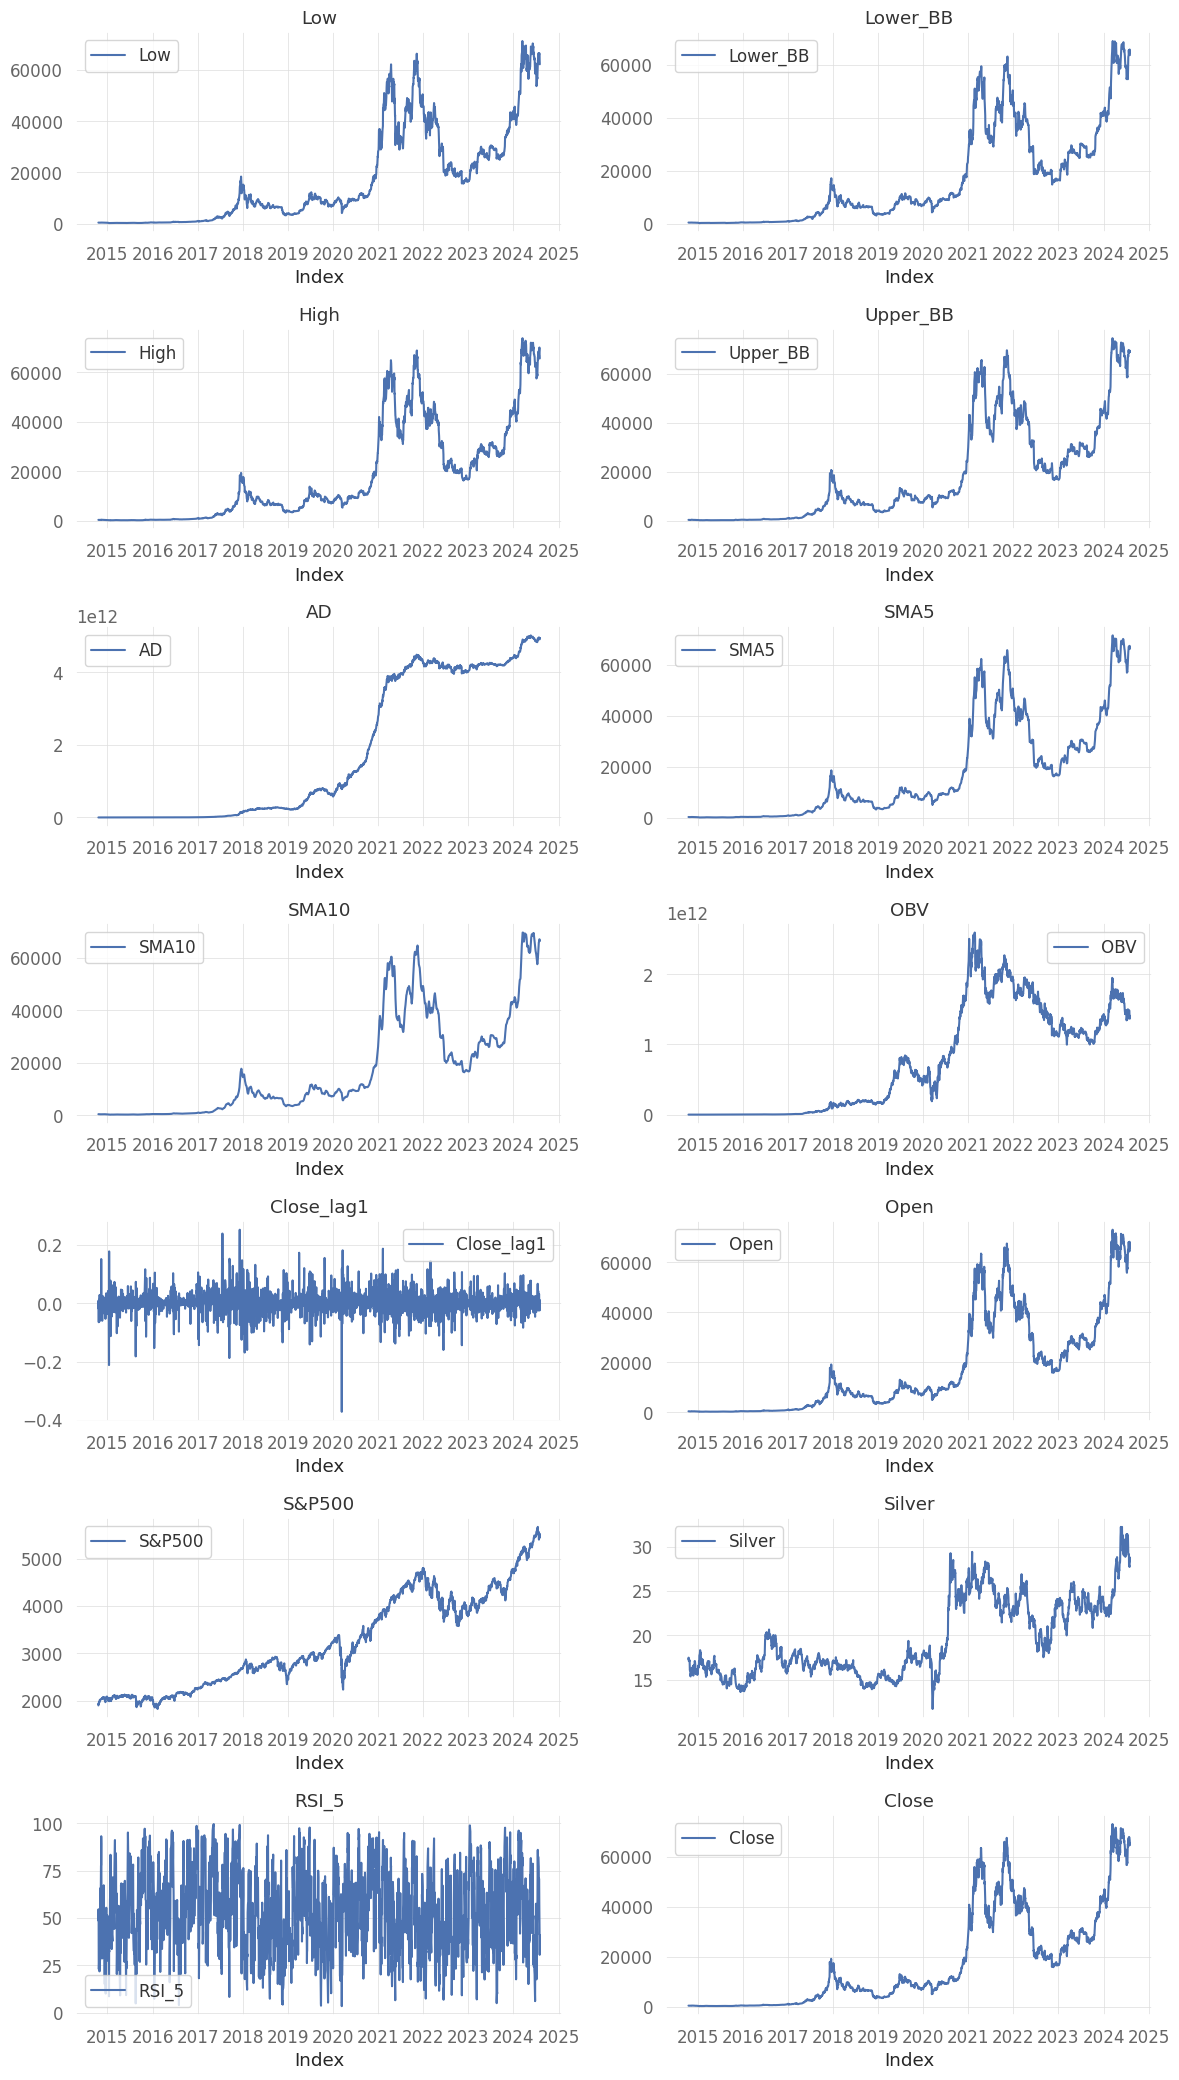

In [ ]:
# Visualization
df_to_plot = btc_data_1[column_to_select].copy()
plot_columns(df_to_plot)

## 2c. Data Temporalization, Data Splitting and Data Scaling

In [ ]:
# Temporalizing the Data: samples x lookback x features
target_column = 'Close'
lookback = 5

# Extract the features and target
input_X, input_y, n_features = input(btc_data_1, target_column)
n_features = input_X.shape[1]

# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print('The shape of X:', X.shape)
print('The shape of y:', y.shape)

# Split into train, valid, and test
X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, DATA_SPLIT_PCT, SEED)

# Reshape
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
TIMESTEPS = X_train.shape[1] # equal to the lookback

print('The shape of train data:', X_train.shape, y_train.shape)
print('The shape of valid data:', X_valid.shape, y_valid.shape)
print('The shape of test data:', y_train.shape, y_test.shape)
print('Lookback:', TIMESTEPS)
print('Number of features:', n_features)

# Scale the training data.
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler_X)
X_valid_scaled = scale(X_valid, scaler_X)
X_test_scaled = scale(X_test, scaler_X)

The shape of X: (2449, 5, 13)
The shape of y: (2449,)
The shape of train data: (1567, 5, 13) (1567,)
The shape of valid data: (392, 5, 13) (392,)
The shape of test data: (1567,) (490,)
Lookback: 5
Number of features: 13


**The sections 4 and 5 present how LSTM and BiLSTM models are trained. The best model performance is saved, then reloading to make future predictions. Similarly, the same process is applied to BiLSTM.**

# 4. BAYESIAN HYPER-PARAMETER TUNING LSTM MODEL



In [ ]:
# Define shape and output
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1] if len(y_train.shape) > 1 else 1  # Adjust based on target shape

# Bayesian-LSTM
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Fit the model
model_bayesian_lstm = bayesian_opt_tuner(lstm_hypermodel, X_train_scaled, y_train, X_valid_scaled, y_valid)
history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'lstm_layer_1': 25, 'dropout_1': 0.4, 'lstm_layer_2': 89, 'dropout_2': 0.2, 'learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 25)               │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 25)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 89)               │          40,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 445)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 445)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             446 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,286 (176.90 KB)

 Trainable params: 45,286 (176.90 KB)

 Non-trainable params: 0 (0.00 B)

None


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


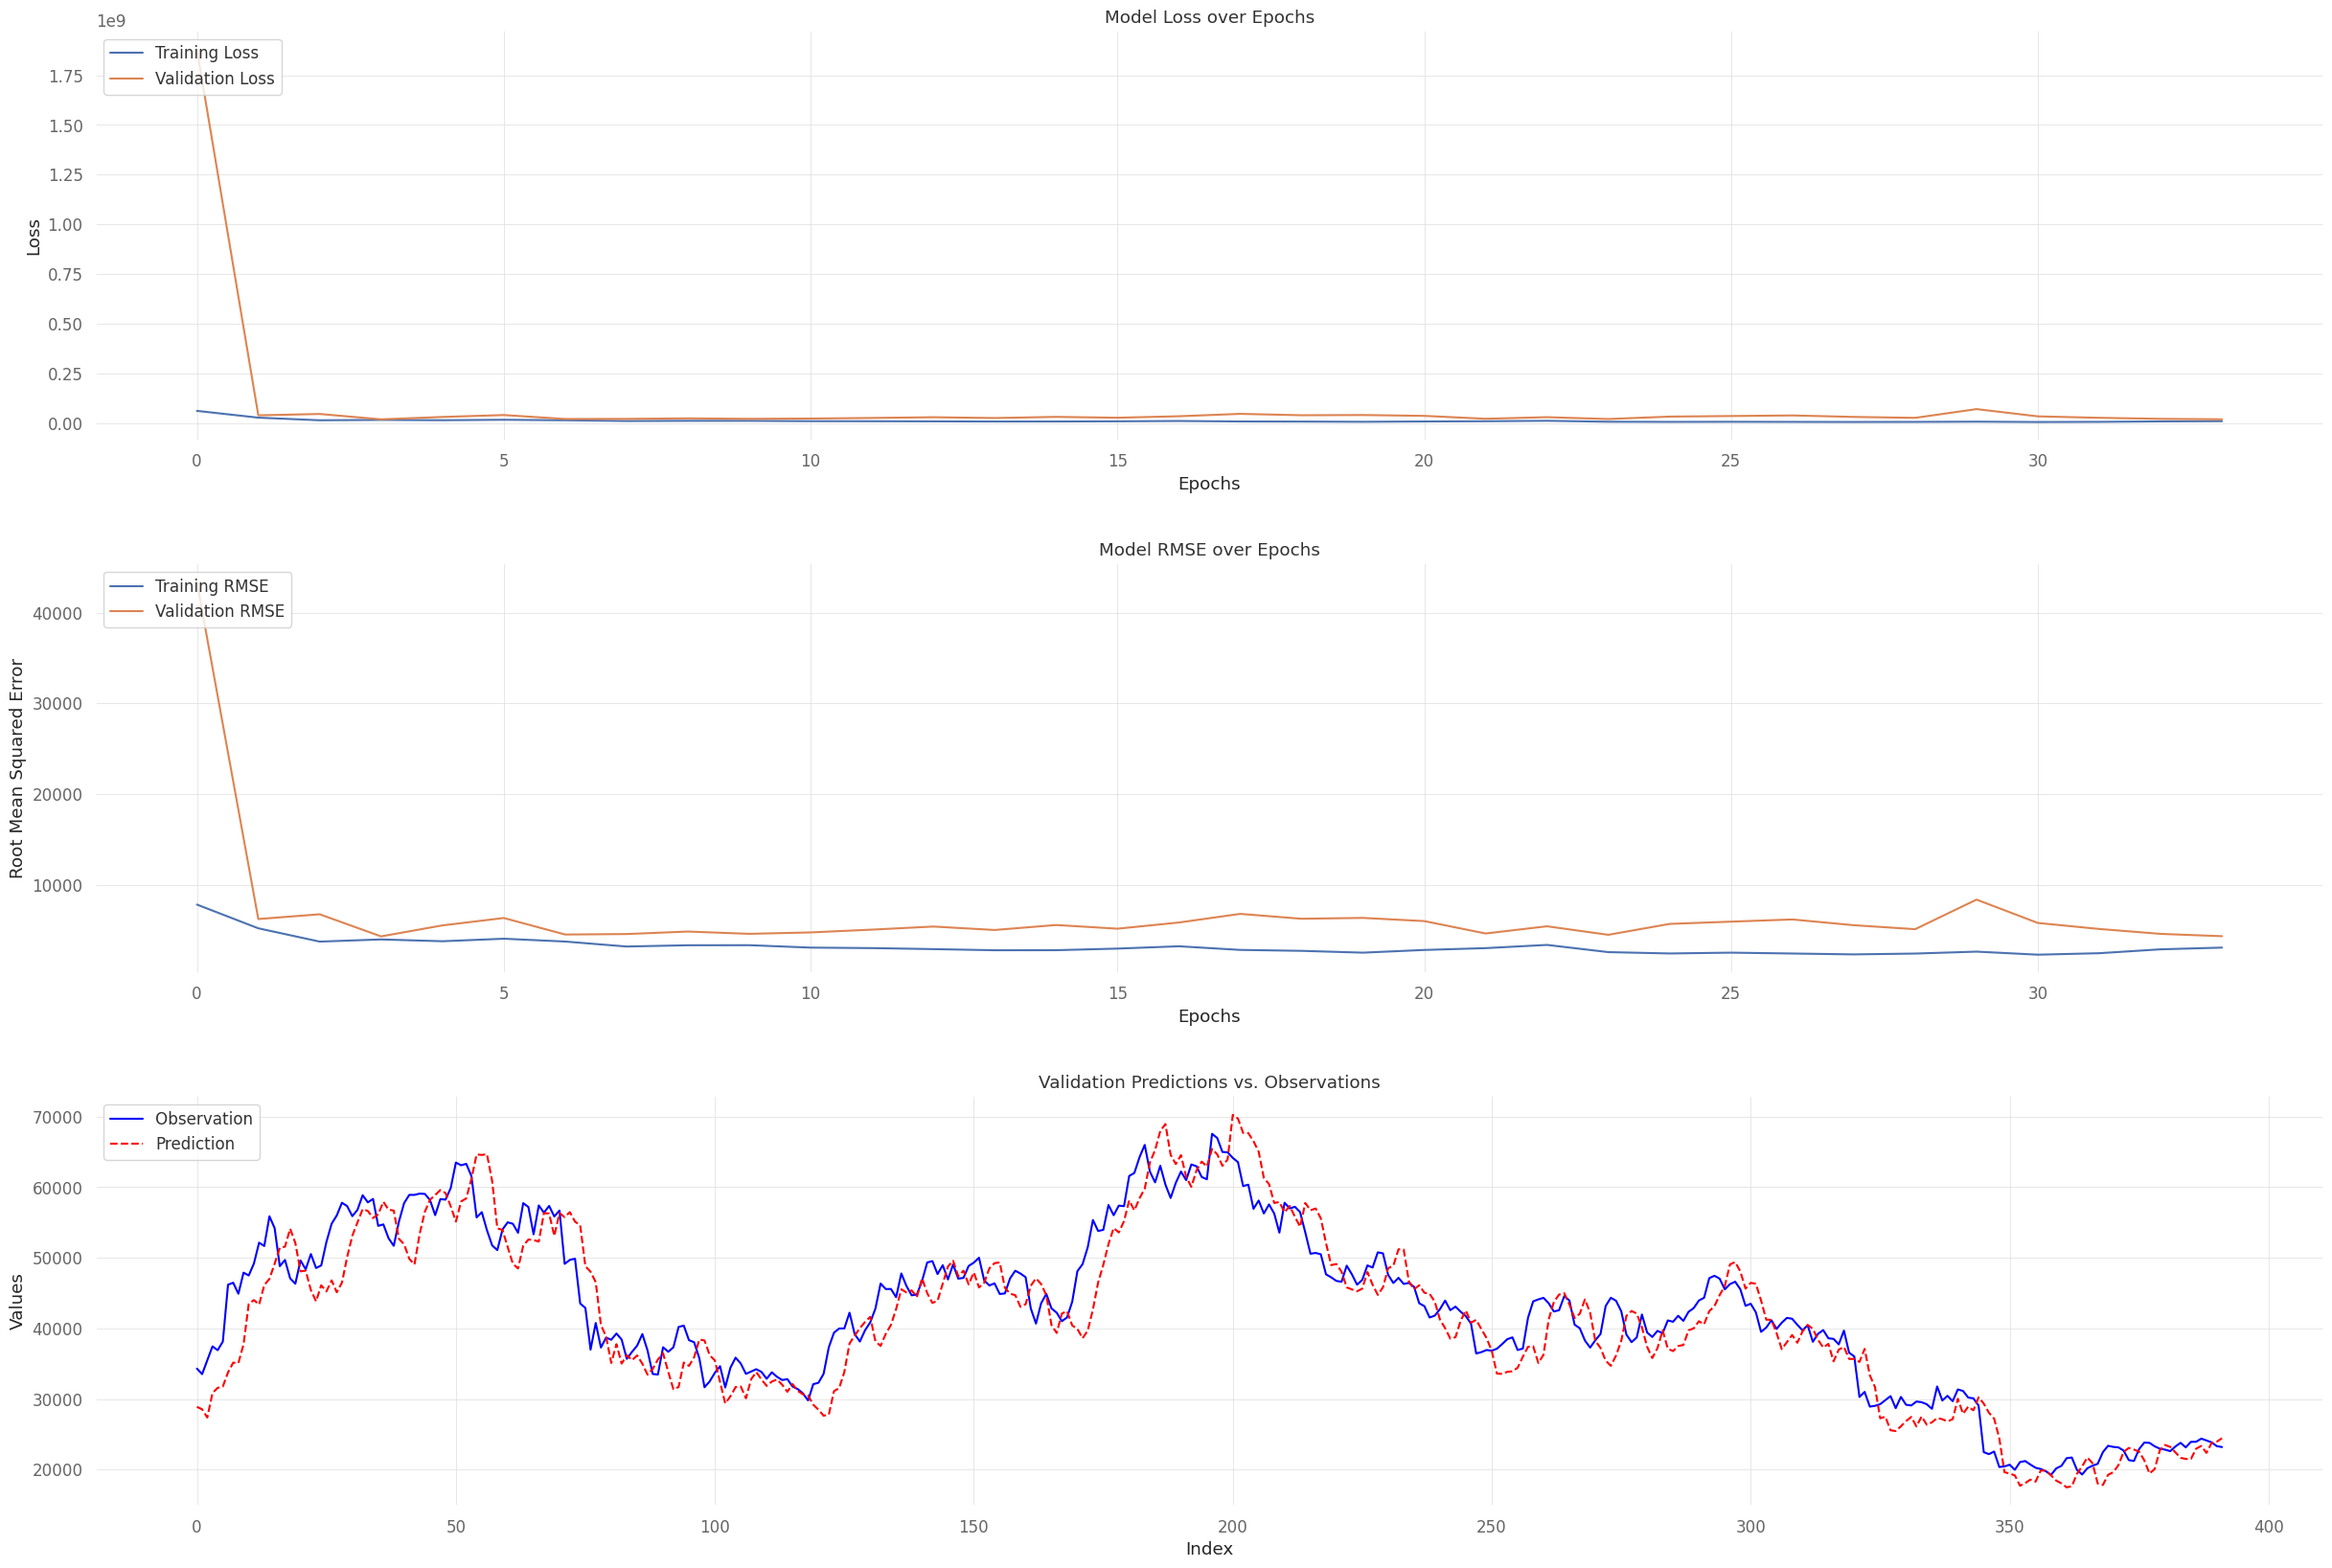

In [ ]:
# Inspect performance on validation data
val_inspection(history_bayesian_lstm, model_bayesian_lstm, X_valid_scaled, y_valid)

In [ ]:
# Step by step to reload the trained model
# Step 1: Save the trained model
model_bayesian_lstm.save('bayesian_lstm_btc.keras')

# Step 2: Load the model
#model_bayesian_lstm = load_model('bayesian_lstm_btc.keras')

# Step 3: Fit the model
#history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

In [ ]:
# Check performance metrics
train_predict_bayesian_lstm = model_bayesian_lstm.predict(X_train_scaled)
valid_predict_bayesian_lstm = model_bayesian_lstm.predict(X_valid_scaled)
test_predict_bayesian_lstm = model_bayesian_lstm.predict(X_test_scaled)

bayesian_lstm_train_mae, bayesian_lstm_train_rmse = evaluate_prediction(train_predict_bayesian_lstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data')
bayesian_lstm_valid_mae, bayesian_lstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_lstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data')
bayesian_lstm_test_mae, bayesian_lstm_test_rmse = evaluate_prediction(test_predict_bayesian_lstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data')

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data:
Mean Absolute Error: 5162.6380
Root Mean Square Error: 7201.5224

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data:
Mean Absolute Error: 13755.2526
Root Mean Square Error: 17016.0202

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data:
Mean Absolute Error: 19975.0272
Root Mean Square Error: 26189.5914



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Out-of-sample R-squared: 0.96
Bayesian-Hyperparameter Tuning LSTM:
Mean Absolute Error: 19975.0272
Root Mean Square Error: 26189.5914



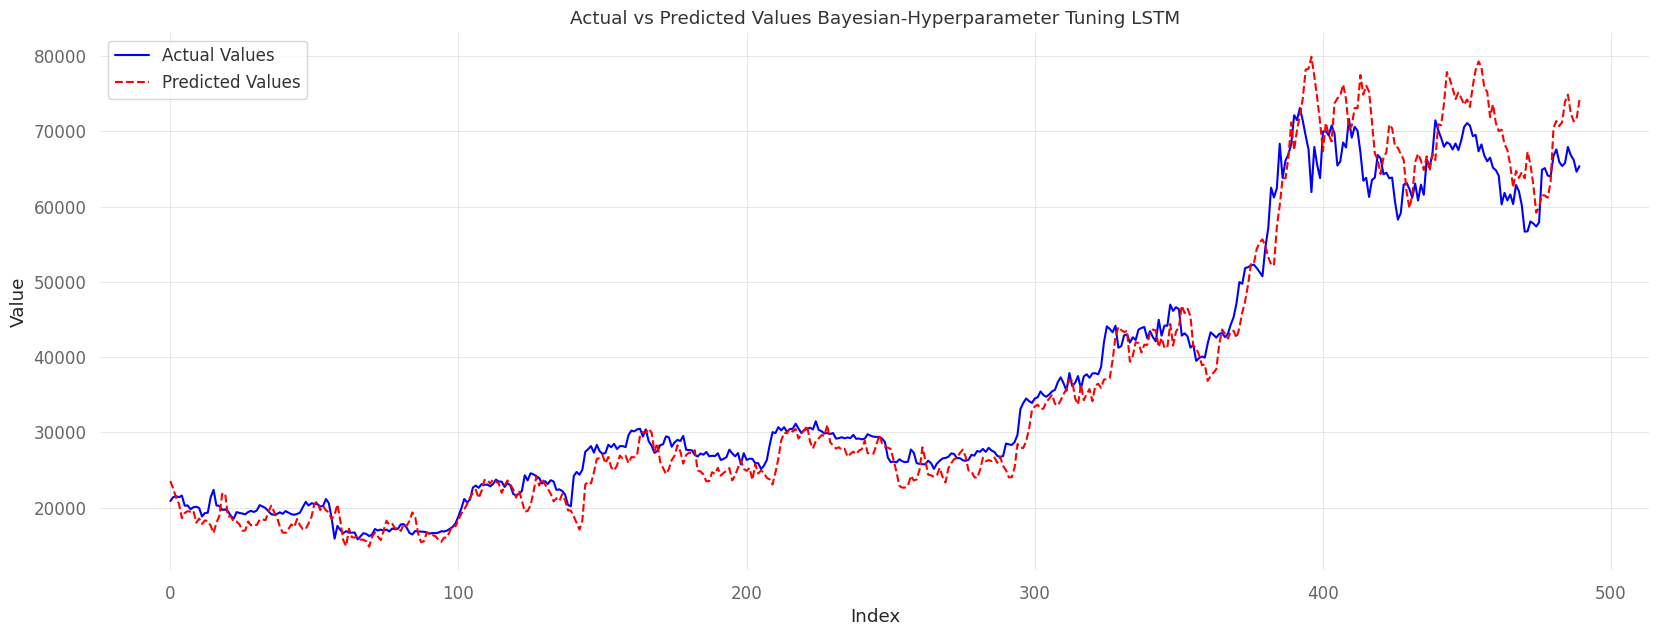

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


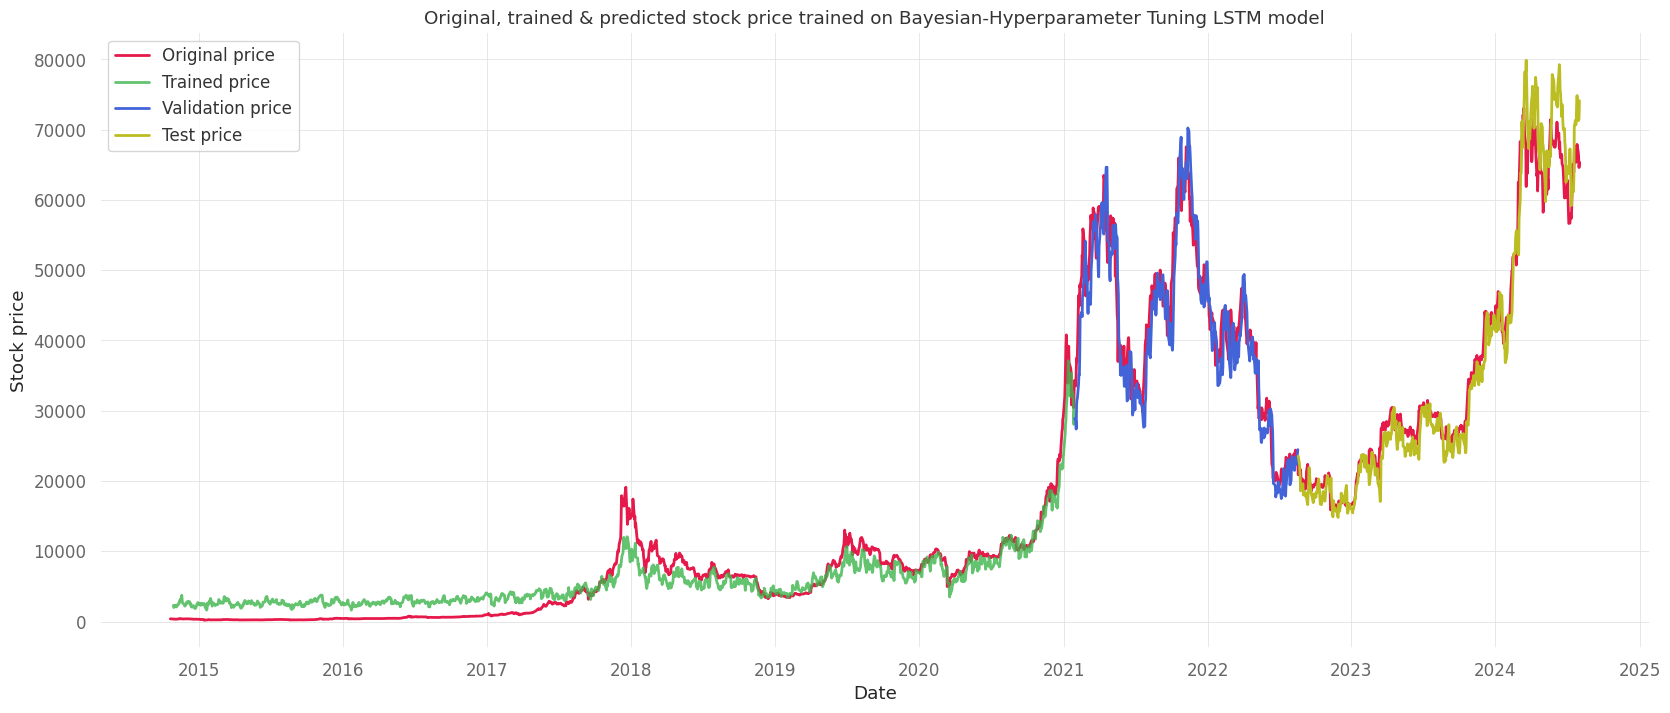

In [ ]:
# Inspect and visualize test performance
bayesian_lstm_predictions = test_inspection(model_bayesian_lstm, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning LSTM')
prediction_bayesian_lstm_df = final_visualization(btc_data_1, lookback, DATA_SPLIT_PCT, SEED, model_bayesian_lstm, X_train_scaled, X_valid_scaled, bayesian_lstm_predictions, btc_data_1[target_column], 'Bayesian-Hyperparameter Tuning LSTM')

# 5. BAYESIAN HYPER-PARAMETER TUNING BILSTM MODEL

In [ ]:
# Instantiate the HyperModel
hypermodel_BILSTM = BILSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Bayesian Optimization
bayesian_bilstm_model = bayesian_opt_tuner(hypermodel_BILSTM, X_train_scaled, y_train, X_valid_scaled, y_valid)
history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'bi_lstm_layer_1': 7, 'dropout_1': 0.2, 'bi_lstm_layer_2': 39, 'dropout_2': 0.2, 'learning_rate': 0.0001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 5, 14)               │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 14)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 5, 78)               │          16,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 390)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 390)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             391 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,415 (71.93 KB)

 Trainable params: 18,415 (71.93 KB)

 Non-trainable params: 0 (0.00 B)

None


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


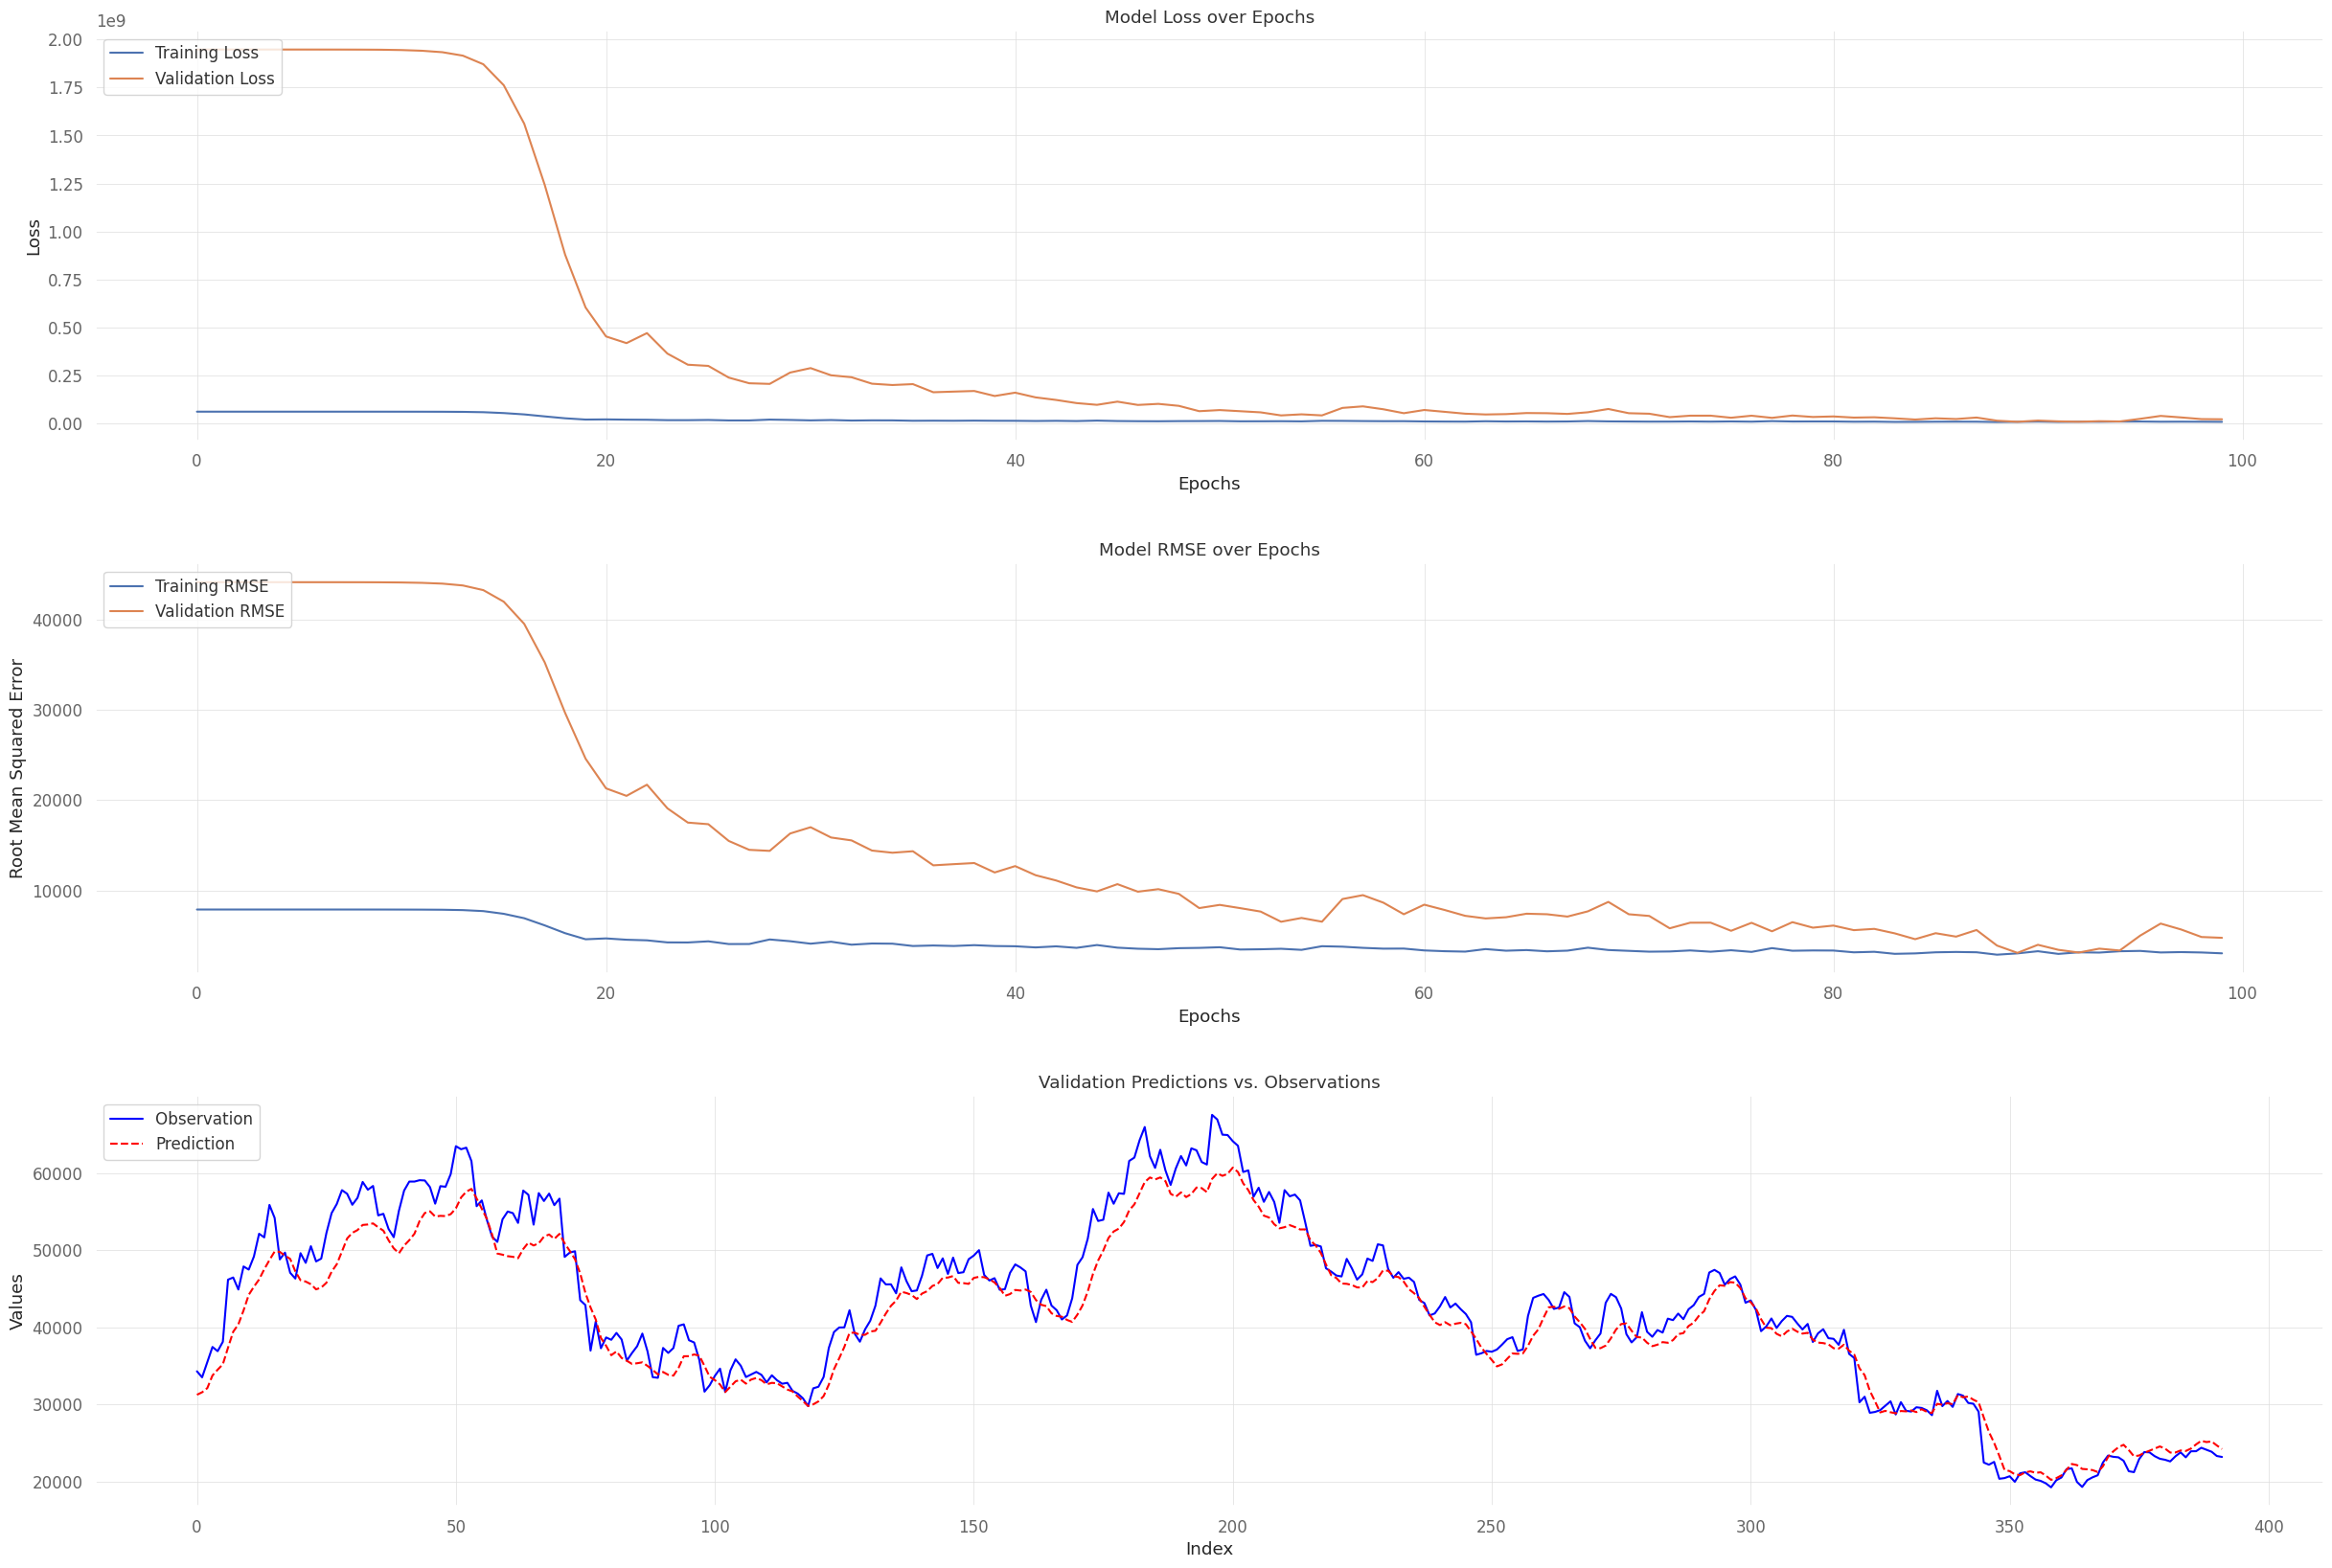

In [ ]:
# Inspect performance on validation data
val_inspection(history_bayesian_bilstm, bayesian_bilstm_model, X_valid_scaled, y_valid)

In [ ]:
# Step by step to reload the trained model
# Step 1: Save the trained model
bayesian_bilstm_model.save('bayesian_bilstm_model_btc.keras')

# Step 2: Load the model
#bayesian_bilstm_model = load_model('bayesian_bilstm_model_btc.keras')

# Step 3: Fit the model
#history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

In [ ]:
# Check performance metrics
train_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_train_scaled)
valid_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_valid_scaled)
test_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_test_scaled)

bayesian_bilstm_train_mae, bayesian_bilstm_train_rmse= evaluate_prediction(train_predict_bayesian_bilstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data')
bayesian_bilstm_valid_mae, bayesian_bilstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_bilstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data')
bayesian_bilstm_test_mae, bayesian_bilstm_test_rmse = evaluate_prediction(test_predict_bayesian_bilstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data')

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data:
Mean Absolute Error: 5221.0911
Root Mean Square Error: 7494.9870

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data:
Mean Absolute Error: 12546.9770
Root Mean Square Error: 15524.9019

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data:
Mean Absolute Error: 17888.9733
Root Mean Square Error: 23257.6339



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Out-of-sample R-squared: 0.97
Bayesian-Hyperparameter Tuning BILSTM:
Mean Absolute Error: 17888.9733
Root Mean Square Error: 23257.6339



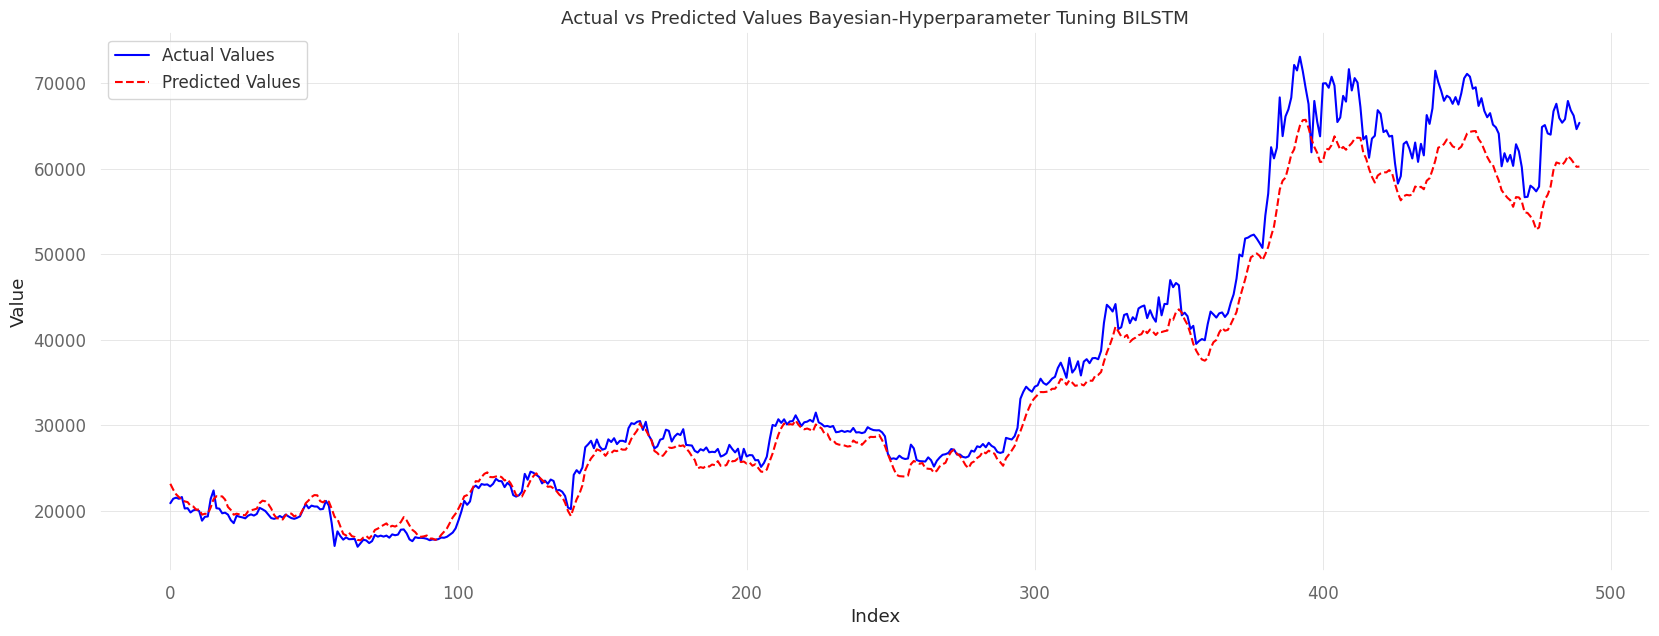

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


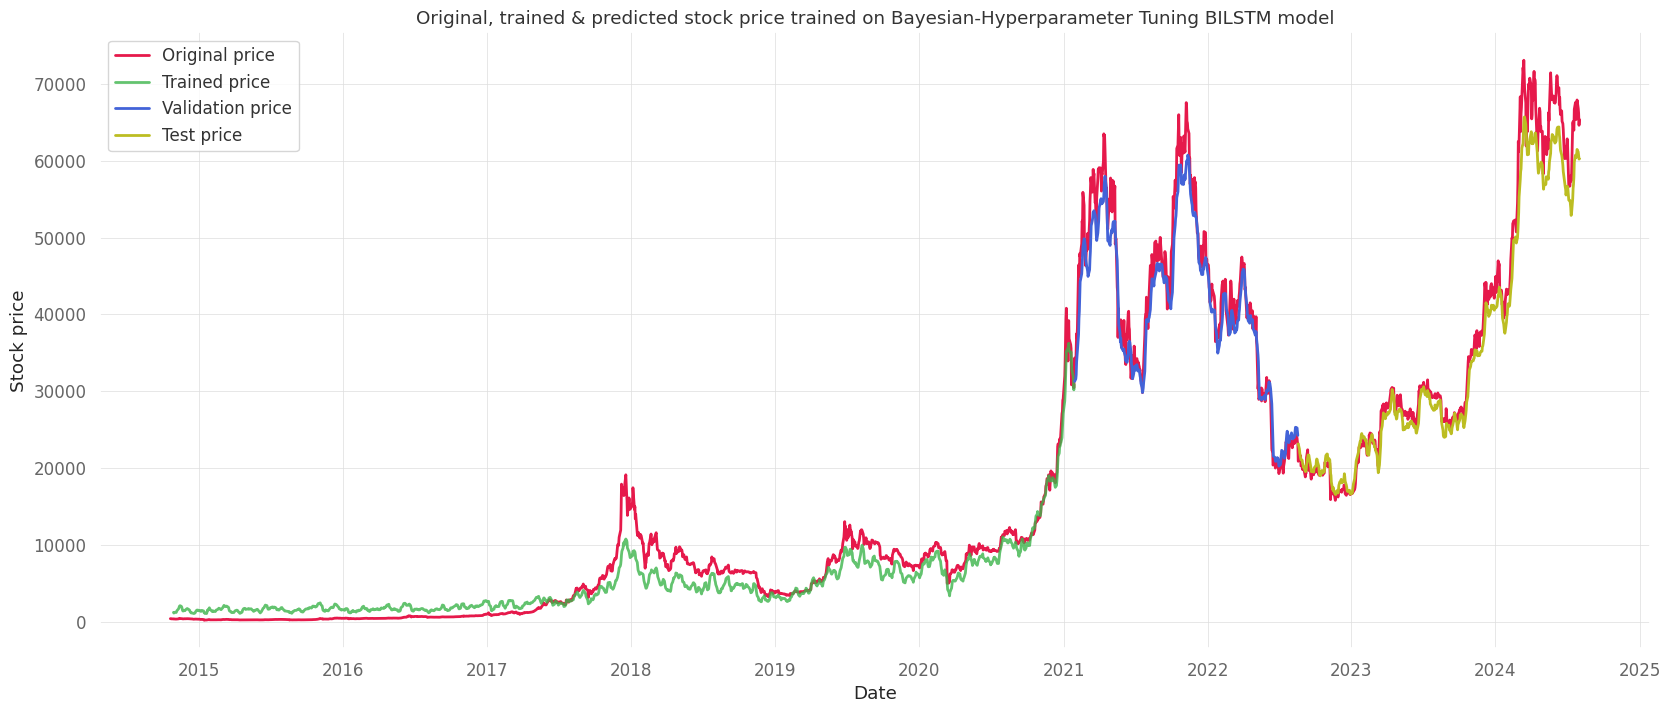

In [ ]:
# Inspect and visualize test performance
bayesian_bilstm_predictions = test_inspection(bayesian_bilstm_model, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning BILSTM')
prediction_bayesian_bilstm_df = final_visualization(btc_data_1, lookback, DATA_SPLIT_PCT, SEED, bayesian_bilstm_model, X_train_scaled, X_valid_scaled, bayesian_bilstm_predictions, btc_data_1[target_column], 'Bayesian-Hyperparameter Tuning BILSTM')

# 6. RESULT - LSTM & BILSTM

In [ ]:
# Define model names
model_names = ['Bayesian_LSTM', 'Bayesian_BILSTM']

# Create a dictionary to store the results
results_dict = {
    'Train_MAE': [bayesian_lstm_train_mae, bayesian_bilstm_train_mae],
    'Train_RMSE': [bayesian_lstm_train_rmse, bayesian_bilstm_train_rmse],
    'Valid_MAE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_mae],
    'Valid_RMSE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_rmse],
    'Test_MAE': [bayesian_lstm_test_mae, bayesian_bilstm_test_mae],
    'Test_RMSE': [ bayesian_lstm_test_rmse, bayesian_bilstm_test_rmse],
    'R2-OOS': [0.96, 0.97]
}

# Display result
results_df = pd.DataFrame(results_dict, index=model_names)
results_df

Train_MAE   Train_RMSE     Valid_MAE    Valid_RMSE  \
Bayesian_LSTM    5162.637967  7201.522362  17016.020183  17016.020183   
Bayesian_BILSTM  5221.091149  7494.987044  12546.976961  15524.901899   

                     Test_MAE     Test_RMSE  R2-OOS  
Bayesian_LSTM    19975.027206  26189.591426    0.96  
Bayesian_BILSTM  17888.973327  23257.633885    0.97

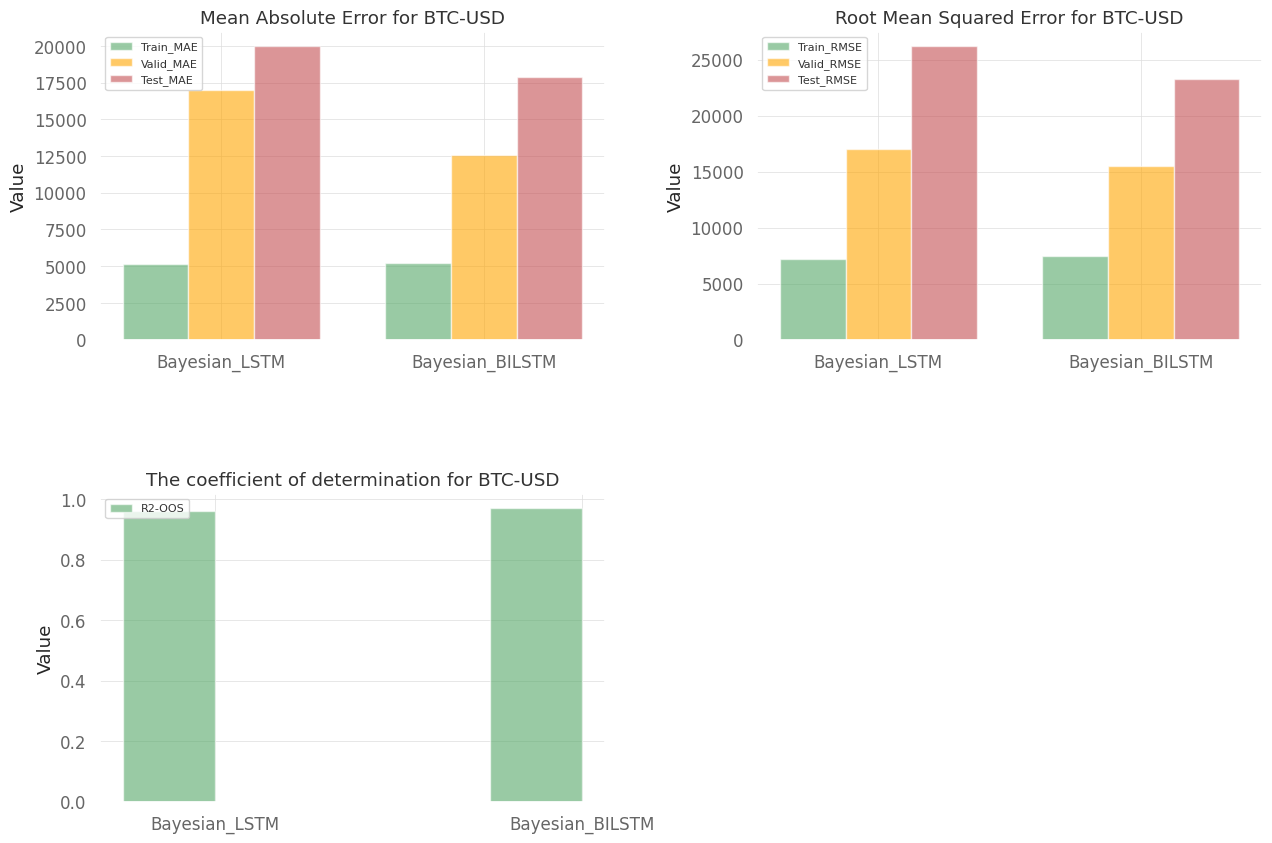

In [ ]:
stock = 'BTC-USD'
x = np.arange(len(results_df))  # Get the positions for the bars
bar_width = 0.25  # Set the width of the bars

fig, axes = plt.subplots(2, 2, figsize=(15,10))  # Create a 2x2 grid for subplots

# Plot first subplot (MAE)
axes[0, 0].bar(x - bar_width, results_df['Train_MAE'], width=bar_width, label='Train_MAE', color='g', alpha=0.6)
axes[0, 0].bar(x, results_df['Valid_MAE'], width=bar_width, label='Valid_MAE', color='orange', alpha=0.6)
axes[0, 0].bar(x + bar_width, results_df['Test_MAE'], width=bar_width, label='Test_MAE', color='r', alpha=0.6)
axes[0, 0].set_title('Mean Absolute Error for {}'.format(stock))
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df.index)
axes[0, 0].legend(loc='upper left', fontsize=8)

# Plot second subplot (RMSE)
axes[0, 1].bar(x - bar_width, results_df['Train_RMSE'], width=bar_width, label='Train_RMSE', color='g', alpha=0.6)
axes[0, 1].bar(x, results_df['Valid_RMSE'], width=bar_width, label='Valid_RMSE', color='orange', alpha=0.6)
axes[0, 1].bar(x + bar_width, results_df['Test_RMSE'], width=bar_width, label='Test_RMSE', color='r', alpha=0.6)
axes[0, 1].set_title('Root Mean Squared Error for {}'.format(stock))
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df.index)
axes[0, 1].legend(loc='upper left', fontsize=8)

# Plot third subplot (R2-OOS)
axes[1, 0].bar(x - bar_width / 2, results_df['R2-OOS'], width=bar_width, label='R2-OOS', color='g', alpha=0.6)
axes[1, 0].set_title('The coefficient of determination for {}'.format(stock))
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df.index)
axes[1, 0].legend(loc='upper left', fontsize=8)

# Remove the fourth subplot (empty)
fig.delaxes(axes[1, 1])  # Remove the last (empty) plot

# Adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the spacing between plots
plt.savefig('result_btc.png', dpi=300)
plt.show()


# 7. DISUSSION - STRATEGY vs. BENCHMARK



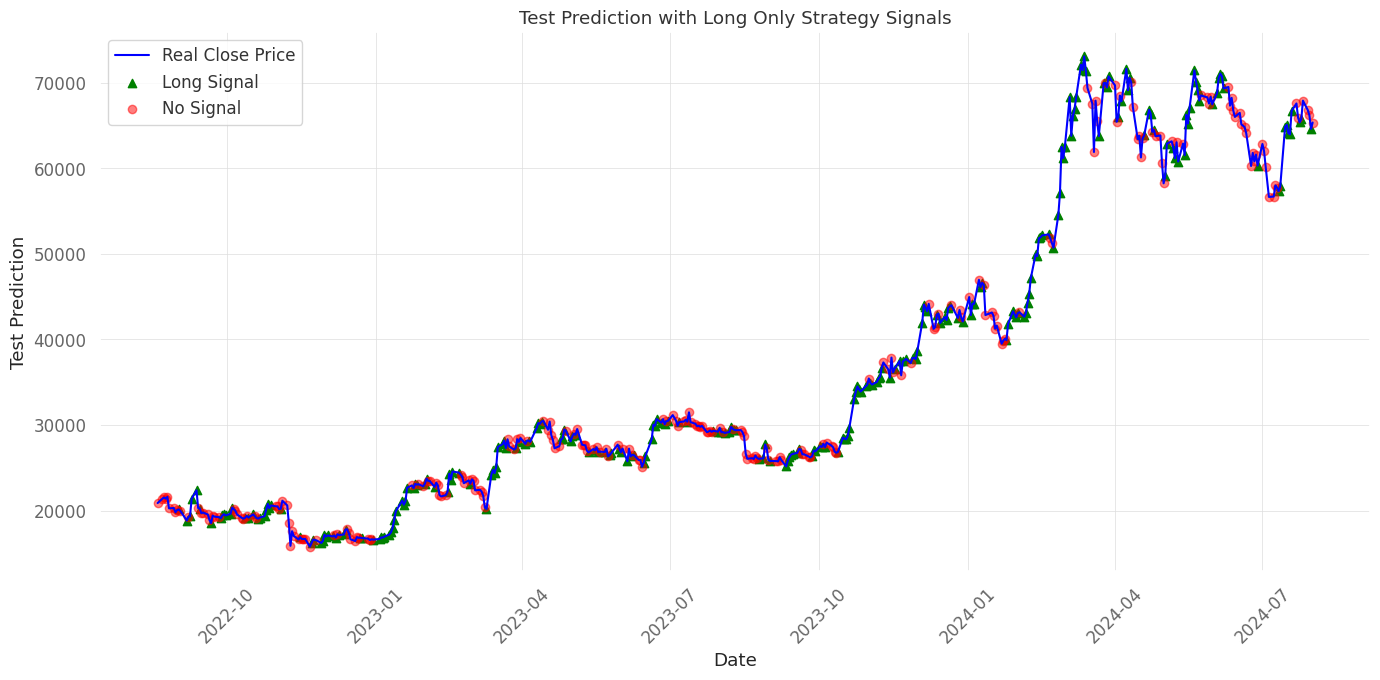

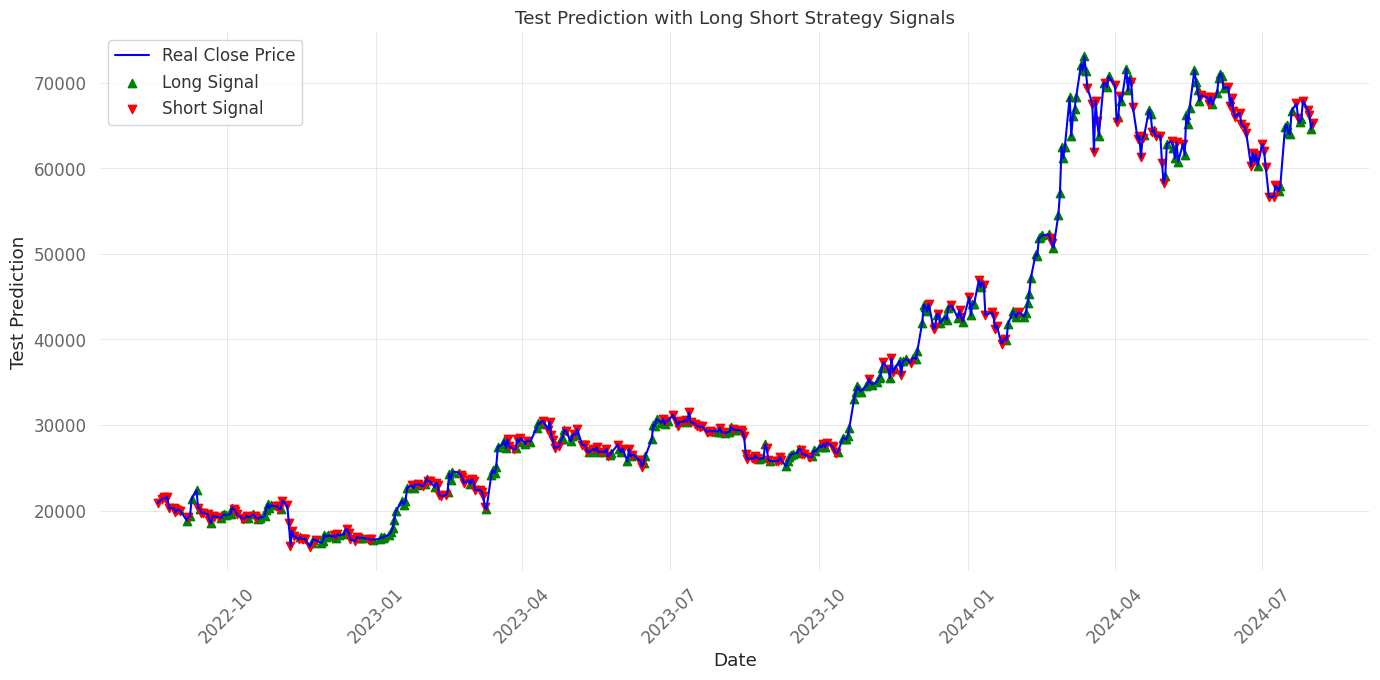

In [ ]:
# Copying prediction results to a new DataFrame
df_prediction = prediction_bayesian_bilstm_df.copy()

# Long-Only
long_only_signal = generate_signals(df_prediction,'Test_Prediction',target='long_only')
df_prediction['Long_Only'] = long_only_signal['Strategy']

# Long-Short
long_short_signal = generate_signals(df_prediction,'Test_Prediction',target='long_short')
df_prediction['Long_Short'] = long_short_signal['Strategy']

# Buy-Hold
df_prediction['Observation'] = y_test
buy_hold_signal = generate_signals(df_prediction,'Observation',target='long_only')
df_prediction['Buy_Hold'] = buy_hold_signal['Strategy']

# Plot the proposed strategies
plot_strategy_signals(df_prediction,'Long Only', strategy='long_only')
plot_strategy_signals(df_prediction,'Long Short', strategy='long_short')

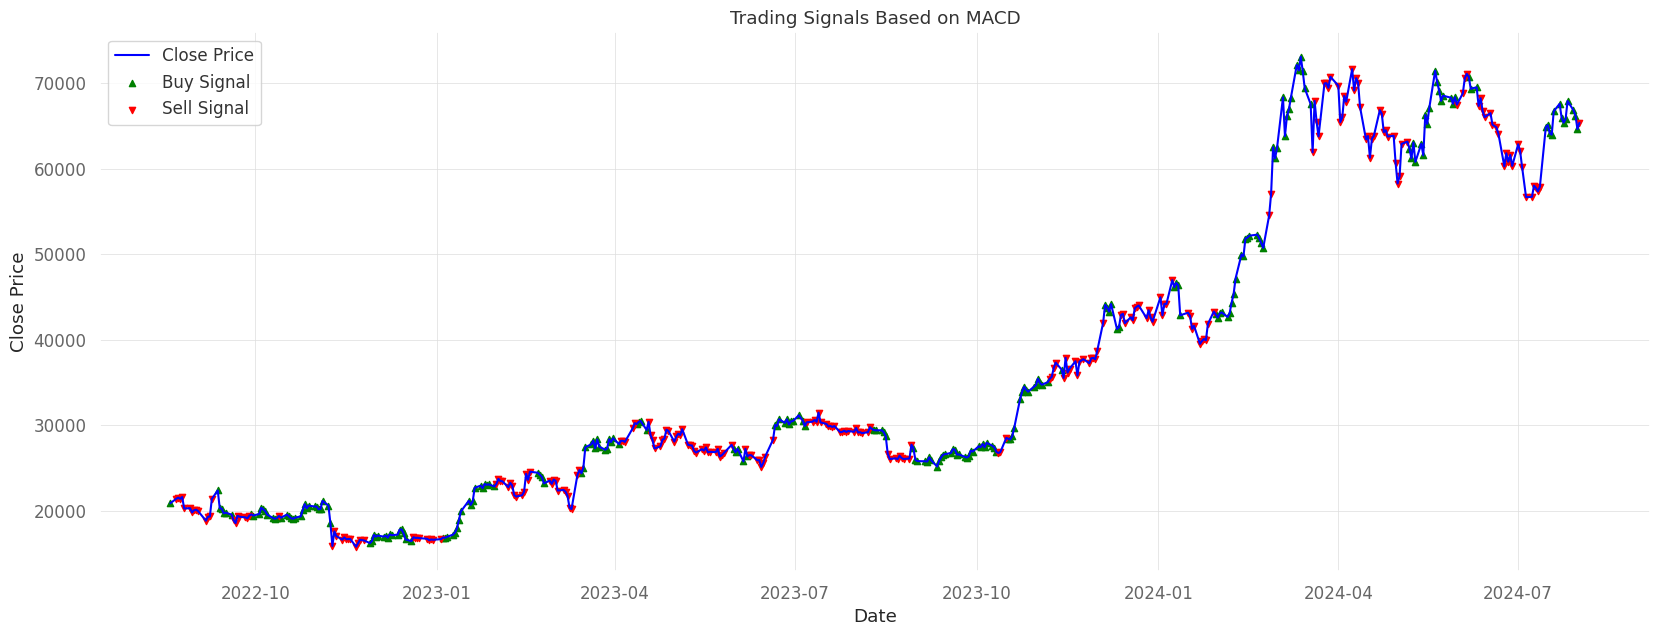

In [ ]:
# Trading strategy based on MACD
# Align with prediction_df index
start_date = df_prediction.index[0]
end_date = df_prediction.index[-1]
filtered_df = btc_data[start_date:end_date]
macd_df = filtered_df[['Close','MACD_Line', 'MACD_Histogram', 'Signal_Line']].copy()

# Shift MACD_line and Signal_Line columns to align with the next time step
macd_df['MACD_line_prev'] = macd_df['MACD_Line'].shift(1)
macd_df['Signal_Line_prev'] = macd_df['Signal_Line'].shift(1)

# Apply the strategy logic
macd_df['MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] >= macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] < macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = -1

# Drop the temporary columns used for calculation
macd_df.drop(columns=['MACD_line_prev', 'Signal_Line_prev'], inplace=True)

# Add to prediction df
df_prediction['MACD_Trading_Signal'] = macd_df['MACD_Trading_Signal']

# Plot MACD strategy
plot_technical_signals(macd_df, 'Close', 'MACD_Trading_Signal', 'MACD')

**CALCULATING PORTFOLIO VALUE OF EACH INDIVIDUAL STRATEGY**

In [ ]:
# Portfolio Value of each individual strategy
df_portfolio_value = calculate_portfolio_values(df_prediction, start_money=1000)
df_portfolio_value

Return  Long_Only_Return  Long_Short_Return  \
2022-08-19  0.000000          0.000000          -0.000000   
2022-08-22  0.024972          0.000000          -0.024972   
2022-08-23  0.006037          0.000000          -0.006037   
2022-08-24 -0.006181         -0.000000           0.006181   
2022-08-25  0.009623          0.000000          -0.009623   
...              ...               ...                ...   
2024-07-26  0.032456          0.000000          -0.032456   
2024-07-29 -0.016082         -0.000000           0.016082   
2024-07-30 -0.009262         -0.000000           0.009262   
2024-07-31 -0.023893         -0.023893          -0.023893   
2024-08-01  0.011425          0.000000          -0.011425   

            MACD_Trading_Return  Portfolio_Value_Buy_Hold  \
2022-08-19             0.000000               1000.000000   
2022-08-22            -0.024972               1024.972059   
2022-08-23            -0.006037               1031.159550   
2022-08-24             0.006181               1024.785798   
2022-08-25            -0.009623               1034.647335   
...                         ...                       ...   
2024-07-26             0.032456               3252.874672   
2024-07-29            -0.016082               3200.562581   
2024-07-30            -0.009262               3170.918377   
2024-07-31            -0.023893               3095.154438   
2024-08-01            -0.011425               3130.515383   

            Portfolio_Value_Long_Only  Portfolio_Value_Long_Short  \
2022-08-19                1000.000000                 1000.000000   
2022-08-22                1000.000000                  975.027941   
2022-08-23                1000.000000                  969.141949   
2022-08-24                1000.000000                  975.132362   
2022-08-25                1000.000000                  965.748641   
...                               ...                         ...   
2024-07-26               15672.695939                60739.355420   
2024-07-29               15672.695939                61716.153792   
2024-07-30               15672.695939                62287.780255   
2024-07-31               15298.222353                60799.515027   
2024-08-01               15298.222353                60104.904025   

            Portfolio_Value_MACD_Trading  
2022-08-19                   1000.000000  
2022-08-22                    975.027941  
2022-08-23                    969.141949  
2022-08-24                    975.132362  
2022-08-25                    965.748641  
...                                  ...  
2024-07-26                    908.060714  
2024-07-29                    893.457460  
2024-07-30                    885.182091  
2024-07-31                    864.032104  
2024-08-01                    854.160871  

[490 rows x 8 columns]

**VISUALIZING THE PORTFOLIO VALUE**

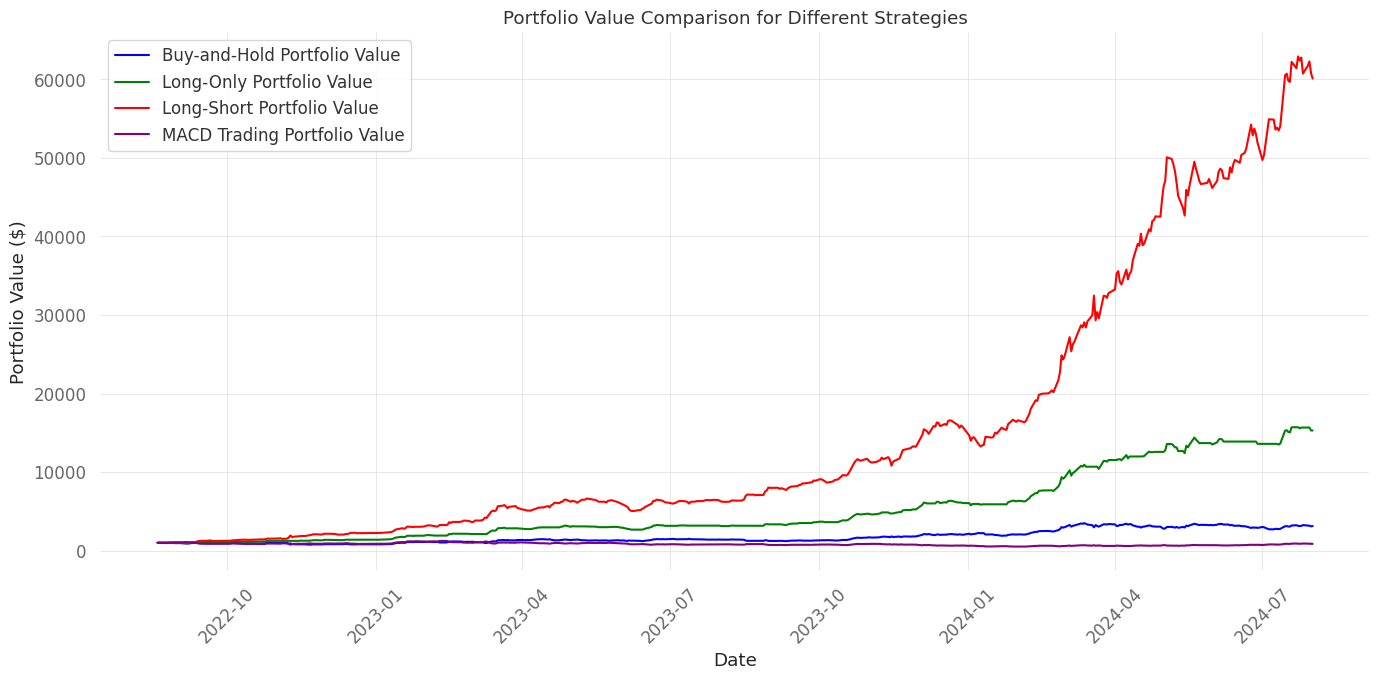

In [ ]:
plot_portfolio_values(df_portfolio_value)

**FULL STATISTIC**

In [ ]:
qs.reports.metrics(df_portfolio_value['Long_Only_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-19   2022-08-19
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             99.0%        53.0%

Cumulative Return          225.98%      1,429.82%
CAGR﹪                     51.84%       162.24%

Sharpe                     1.45         3.9
Prob. Sharpe Ratio         98.11%       100.0%
Smart Sharpe               1.35         3.64
Sortino                    2.41         10.59
Smart Sortino              2.25         9.9
Sortino/√2                 1.7          7.49
Smart Sortino/√2           1.59         7.0
Omega                      2.91         2.91

Max Drawdown               -29.43%      -15.81%
Longest DD Days            141          64
Volatility (ann.)          50.92%       37.87%
R^2                        0.59         0.59
Information Ratio          0.14         0.14
Calmar             

In [ ]:
qs.reports.metrics(df_portfolio_value['Long_Short_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-19   2022-08-19
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          213.05%      5,910.49%
CAGR﹪                     49.68%       325.34%

Sharpe                     1.4          4.52
Prob. Sharpe Ratio         97.76%       100.0%
Smart Sharpe               1.35         4.35
Sortino                    2.31         9.54
Smart Sortino              2.23         9.19
Sortino/√2                 1.64         6.75
Smart Sortino/√2           1.58         6.5
Omega                      2.33         2.33

Max Drawdown               -29.43%      -24.03%
Longest DD Days            141          97
Volatility (ann.)          51.2%        49.43%
R^2                        0.02         0.02
Information Ratio          0.14         0.14
Calmar           

In [ ]:
qs.reports.metrics(df_portfolio_value['MACD_Trading_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-19   2022-08-19
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          213.05%      -14.58%
CAGR﹪                     49.68%       -5.42%

Sharpe                     1.4          0.1
Prob. Sharpe Ratio         97.76%       55.61%
Smart Sharpe               1.24         0.09
Sortino                    2.31         0.14
Smart Sortino              2.05         0.13
Sortino/√2                 1.64         0.1
Smart Sortino/√2           1.45         0.09
Omega                      1.02         1.02

Max Drawdown               -29.43%      -58.68%
Longest DD Days            141          536
Volatility (ann.)          51.2%        51.4%
R^2                        0.04         0.04
Information Ratio          -0.05        -0.05
Calmar              